# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 11.5

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
from sklearn.dummy import DummyClassifier

random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:, 1]
y_random  # После перезапуска ячеек случайные значения заменились на 0.5. Видимо поменяли в новых версиях pandas'a

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: Эти дробные числа - вероятность верного класса. Уже по этим вероятностям можно подбирать threshold, после которого числа уже примут бинарныей вид 0/1

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [4]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


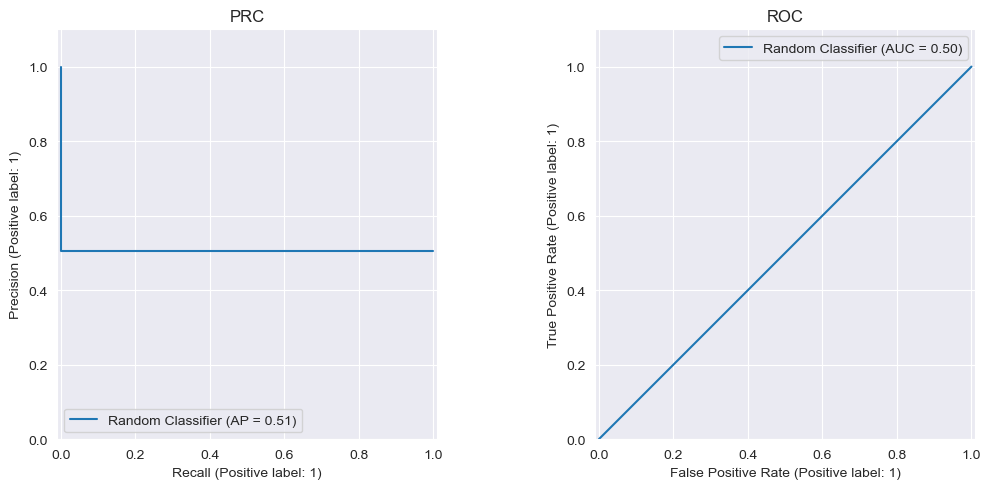

In [5]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [6]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
    average_precision_score(y_test, y_random),
    roc_auc_score(y_test, y_random),
    0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [7]:
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# По примеру из документации - https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
# только добавлю к нему scorer

svc = SVC(kernel="linear", random_state=0, probability=True)
distributions = dict(C=uniform(loc=0, scale=4))
score = make_scorer(average_precision_score, greater_is_better=True)
# надеюсь под метрикой имелся в виду average_precision_score, как в примере выше

grid = RandomizedSearchCV(svc, distributions, scoring=score, random_state=0)

In [8]:
search = grid.fit(X_train, y_train)
search.best_params_  # за 8 минут {'C': 2.4110535042865755}

{'C': 2.4110535042865755}

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

linear SVC metrics
AUC-PR: 0.8152
AUC-ROC: 0.8479


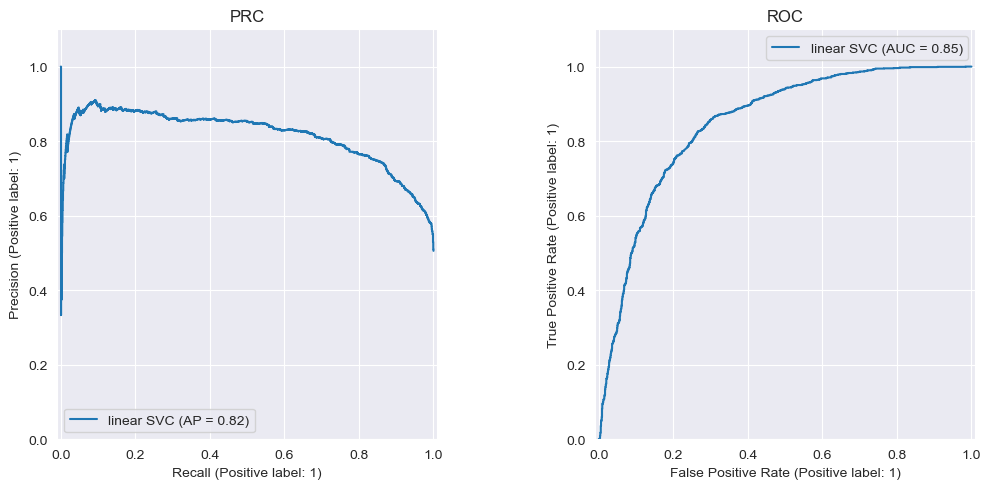

In [9]:
linear_svc = SVC(kernel="linear", random_state=0, probability=True, C=2.4110535042865755)
linear_svc.fit(X_train, y_train)

y_linear_svc_predict = linear_svc.predict_proba(X_test)[:, 1]

depict_pr_roc(y_test, y_linear_svc_predict, 'linear SVC')

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

**Ответ**: При увеличении порога precision увеличивается, а recall уменьшается (модель становится более строгой). у auc roc tpr и fpr уменьшаются пре увеличении порога 

Вообще pr кривая не монотонная, но в данном случае получилась монотонной. Не монотонная, поскольку знаменатель у precision увеличивается с количеством позитивных таргетов (то есть precision не монотонен, а recall монотонно возрастает)
а roc кривая всегда монотонна. Поскольку кривая может либо возрастать (если в отсортированном по вероятностям списке это истинный класс), либо не изменяться (если в отсортированном по вероятностям списке это ложный класс). Ну ещё может идти по диагонали, если вероятности нескольких объектов совпадают. Вниз идти кривая никак не может.

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [10]:
# добавление очередной строки с характеристиками метода
df_metrics.loc['Linear SVC'] = [
    average_precision_score(y_test, y_linear_svc_predict),
    roc_auc_score(y_test, y_linear_svc_predict),
    0,  # без регуляризации?
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.0
Linear SVC,0.815235,0.847886,0.0


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# По примеру из документации - https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
# только добавлю к нему scorer

svc = LogisticRegression(random_state=0)
distributions = dict(C=uniform(loc=0, scale=4))
score = make_scorer(average_precision_score, greater_is_better=True)
# надеюсь под метрикой имелся в виду average_precision_score, как в примере выше

grid = RandomizedSearchCV(svc, distributions, scoring=score, random_state=0, cv=100)
# Работает быстро, а чем ближе к one out, тем лучше 

In [12]:
search_logreg = grid.fit(X_train, y_train)
search_logreg.best_params_  # {'C': 2.195254015709299}

{'C': 2.195254015709299}

Logistic Regression metrics
AUC-PR: 0.8294
AUC-ROC: 0.8479


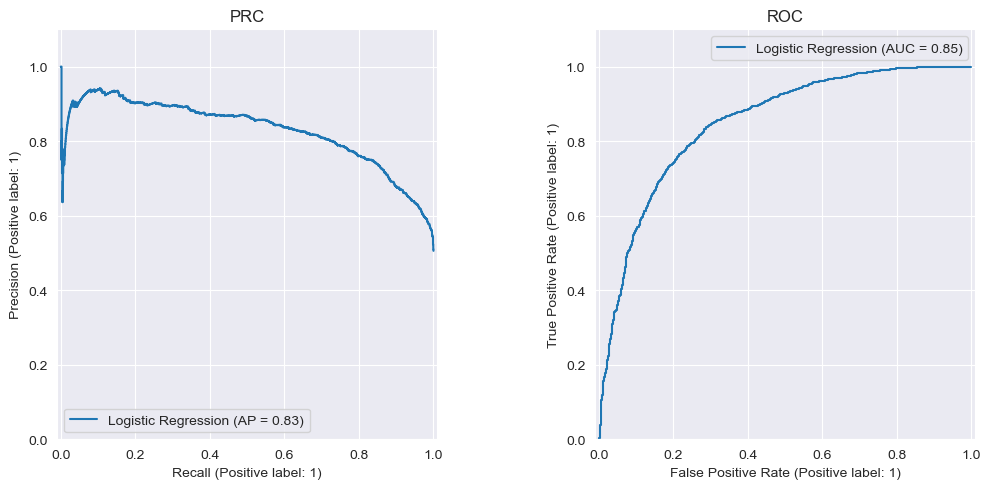

In [13]:
logreg = LogisticRegression(random_state=0, C=2.195254015709299)
logreg.fit(X_train, y_train)

y_logreg_predict = logreg.predict_proba(X_test)[:, 1]

depict_pr_roc(y_test, y_logreg_predict, 'Logistic Regression')

In [14]:
# добавление очередной строки с характеристиками метода
df_metrics.loc['Logistic Regression'] = [
    average_precision_score(y_test, y_logreg_predict),
    roc_auc_score(y_test, y_logreg_predict),
    0,  # без регуляризации?
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.0
Linear SVC,0.815235,0.847886,0.0
Logistic Regression,0.829384,0.847873,0.0


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000
Linear SVC metrics
AUC-PR: 0.8152
AUC-ROC: 0.8479
Logistic Regression metrics
AUC-PR: 0.8294
AUC-ROC: 0.8479


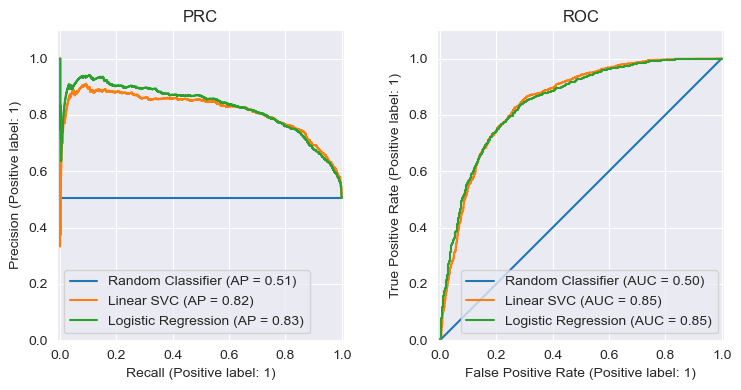

In [15]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
predicts = [y_random, y_linear_svc_predict, y_logreg_predict]
classifier_names = ["Random Classifier", "Linear SVC", "Logistic Regression"]

for predict, classifier_name in zip(predicts, classifier_names):
    depict_pr_roc(y_test, predict, classifier_name, ax=ax)

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Очевидно, случайный классификатор показал значения 0.5, что и соответствуют случайному классификатору. auc roc у svm и логистической регрессии оказался одинаковый. AUC-PR у логистической регрессии оказался чуточку лучше, чем у svm. Объяснить можно... Ну просто случайностью или особенностью данных, каких то значимых значений нет

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [16]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
svc = SVC(kernel='linear', probability=True, random_state=42)  # С подбирать не требовали

svc.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

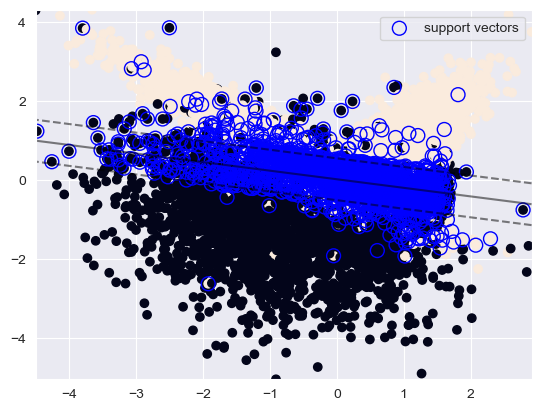

In [18]:
def plot_svm_2D(X, y, model, plot_support=True):
    # создали сетку
    xx = np.linspace(X[:, 0].min(), X[:, 0].max(), 30)
    yy = np.linspace(X[:, 1].min(), X[:, 1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(30, 30)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(X[:, 0],
                X[:, 1],
                c=y
                )

    # Отрисовали опорные векторы
    if plot_support:
        plt.scatter(
            model.support_vectors_[:, 0],
            model.support_vectors_[:, 1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()


plot_svm_2D(X, y, svc)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Выделяются объекты около разделяющей прямой. Не знаю что ещё добавить

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [19]:
logreg = LogisticRegression(random_state=42)  # опять нет требований к подбору гиперпараметров (старые не подоёдут)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

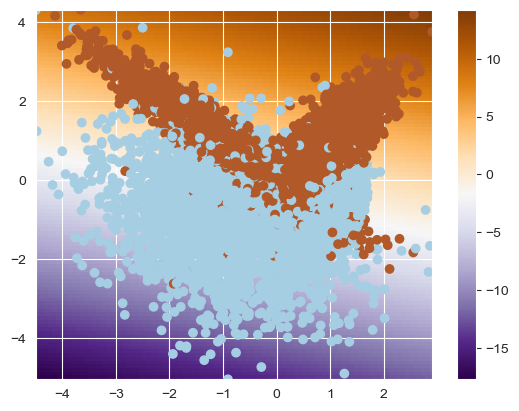

In [20]:
def plot_logreg_2D(X, y, model):
    # создали сетку
    xx = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    yy = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.decision_function(xy)
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(
        X[:, 0],
        X[:, 1],
        c=y,
        cmap=plt.cm.Paired
    )

    plt.colorbar(image)


plot_logreg_2D(X, y, logreg)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Модель не уверена на границе между фиолетовым и оранжевым цветами (Где значение логит функции равно 0). Это можно обосновать как область, где вероятность обоих классов равна 0.5, что соответствует решающей гиперплоскости модели.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [21]:
def plot_calibration_curve(y_test, preds, classifier_name, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(6, 6))
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)  # минус на плюс
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))  # min на mean
    ax.plot(bin_middle_points, bin_real_ratios, label=classifier_name)
    ax.set_ylim([-0.05, 1.05])
    ax.legend()
    ax.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [22]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
from sklearn.svm import SVC

# Тут уже можно исопльзовать подобранный C, ведь датасет тот же самый (тот же random_state генерации)
linear_svc = SVC(kernel="linear", random_state=0, probability=True, C=2.4110535042865755)
linear_svc.fit(X_train, y_train)

y_linear_svc_predict = linear_svc.predict_proba(X_test)[:, 1]

In [24]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=0, C=2.195254015709299)
logreg.fit(X_train, y_train)

y_logreg_predict = logreg.predict_proba(X_test)[:, 1]

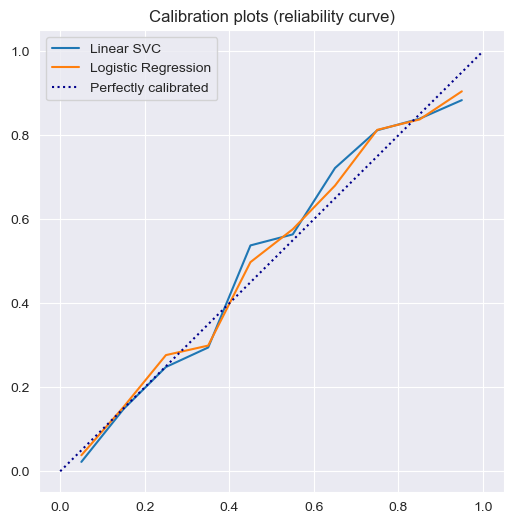

In [25]:
_, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_calibration_curve(y_test, y_linear_svc_predict, 'Linear SVC', ax)
plot_calibration_curve(y_test, y_logreg_predict, 'Logistic Regression', ax)

ax.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), color='#00008B', linestyle='dotted', label='Perfectly calibrated')

ax.set_title('Calibration Curves', fontsize=14)
ax.legend(loc='best')

ax.set_title('Calibration plots (reliability curve)')

plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** Да, оба отклабированы неплохо (но не идеально). В целом обе кривые достаточно похожи, но SVM чуть похуже

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [26]:
from sklearn.metrics import log_loss, brier_score_loss  # никто не просил их реализовывать

print(f"SVM LogLoss: {log_loss(y_test, y_linear_svc_predict)}")
print(f"Linear Regression LogLoss: {log_loss(y_test, y_logreg_predict)}")
print()
print(f"SVM BrierScore: {brier_score_loss(y_test, y_linear_svc_predict)}")
print(f"Linear Regression BrierScore: {brier_score_loss(y_test, y_logreg_predict)}")



SVM LogLoss: 0.48728335549466495
Linear Regression LogLoss: 0.48585513640150163

SVM BrierScore: 0.1580928573251845
Linear Regression BrierScore: 0.15858234017513168


*Вывод:* Из формальных способов также видно, что SVM чуть хуже

Изучите распределение ответов классификаторов при помощи гистограмм

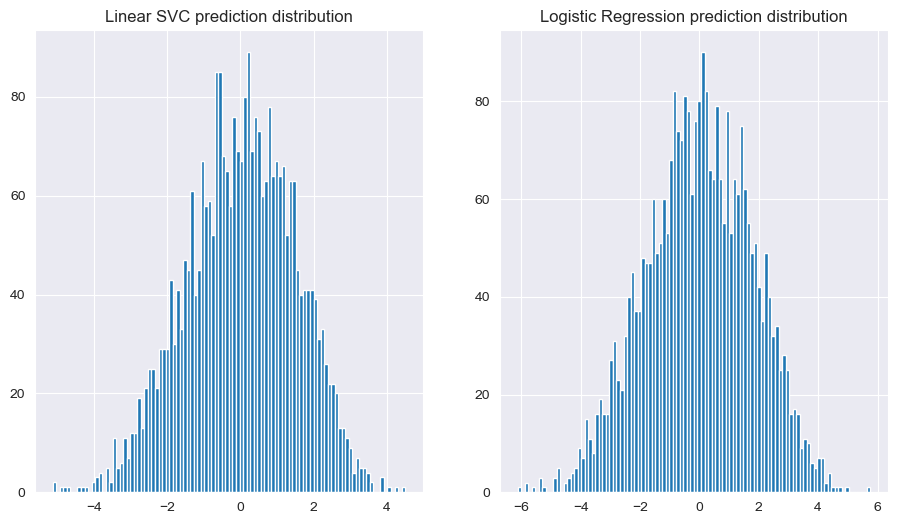

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(11, 6))

ax[0].hist(linear_svc.decision_function(X_test), bins=100)
ax[1].hist(logreg.decision_function(X_test), bins=100)

ax[0].set_title('Linear SVC prediction distribution')
ax[1].set_title('Logistic Regression prediction distribution')

plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Оба распределения довольно похожи и имеют нормальное распределение. Единственное отличие, которое я заметил, это более широкий диапозон у логистической регрессии (от -6 до 6), чем у SVM (от -5 до 4). Это можно объяснить тем, что логистическая регрессия использует сигмоидальную функцию для предсказания вероятностей, которая имеет более плавные границы. SVM в свою очередь оптимизирует границу разделения классов, что делает значения чуть менее вариативным из-за ориентирования на опорные вектора.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [28]:
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

linear_svc = SVC(kernel="linear", random_state=0, probability=True, C=2.4110535042865755)
calibrated_linear_svc = CalibratedClassifierCV(linear_svc, cv=10)

calibrated_linear_svc.fit(X_train, y_train)

y_calibrated_linear_svc_predict = calibrated_linear_svc.predict_proba(X_test)[:, 1]

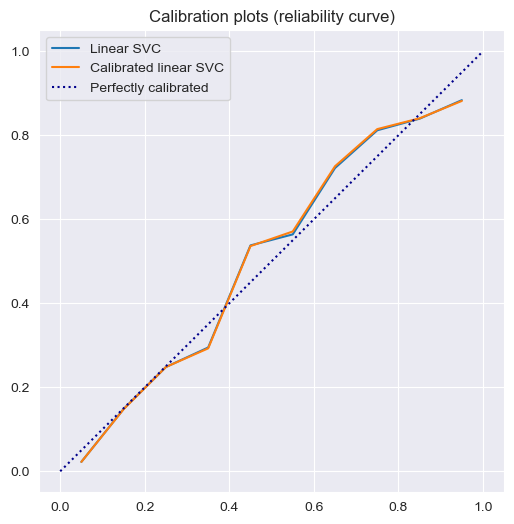

In [29]:
_, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_calibration_curve(y_test, y_linear_svc_predict, 'Linear SVC', ax)
plot_calibration_curve(y_test, y_calibrated_linear_svc_predict, 'Calibrated linear SVC', ax)

ax.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), color='#00008B', linestyle='dotted', label='Perfectly calibrated')

ax.set_title('Calibration Curves', fontsize=14)
ax.legend(loc='best')

ax.set_title('Calibration plots (reliability curve)')

plt.show()

In [30]:
from sklearn.metrics import log_loss, brier_score_loss  # никто не просил их реализовывать

print(f"SVM LogLoss: {log_loss(y_test, y_linear_svc_predict)}")
print(f"Calibrated SVM LogLoss: {log_loss(y_test, y_calibrated_linear_svc_predict)}")
print()
print(f"SVM BrierScore: {brier_score_loss(y_test, y_linear_svc_predict)}")
print(f"Calibrated SVM BrierScore: {brier_score_loss(y_test, y_calibrated_linear_svc_predict)}")

SVM LogLoss: 0.48728335549466495
Calibrated SVM LogLoss: 0.487309718999605

SVM BrierScore: 0.1580928573251845
Calibrated SVM BrierScore: 0.15814368522375677


**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** Нет. Как будто калибровочная кривая и качество стали только чуточку хуже

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [31]:
# не

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [32]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") + "/bike_buyers.csv"

In [33]:
# Прочитаем датасет
df = pd.read_csv(path)

# Дропну Id
df = df.drop(columns=["ID"])

# Типы переменных 
# Приму Children и Cars как числовой за неимением label энкодера в задании
cat_features = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']
num_features = ['Income', 'Children', 'Cars', 'Age']

# Заменим пропуски категориальных переменных
df[cat_features] = df[cat_features].fillna('undefined')

# Отделим X и y
X, y = df.drop(columns=['Purchased Bike']), df['Purchased Bike'].map({'Yes': 1, 'No': 0})

# Разделим на категориальные признаки и числовые
X_numerical = df[num_features]
X_categorical = df[cat_features]

В начале поработаем только с категориальными признаками

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [35]:
# Видимо численные признаки использовать не требуется
import time
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score  # Выше в коде задания как auc pr использовали эту функцию

start_time = time.time()  # Буду тестировать время один раз (%%time не сработало локально)

encoder = OrdinalEncoder()

X_train_ordinal_encoded = encoder.fit_transform(X_train)
X_test_ordinal_encoded = encoder.transform(X_test)

# С желательно снова подобрать С (но это, опять же, не требуют)
logreg = LogisticRegression(random_state=777)
logreg.fit(X_train_ordinal_encoded, y_train)

y_logreg_predict_ord_enc = logreg.predict_proba(X_test_ordinal_encoded)[:, 1]

logreg_ord_enc_execution_time = time.time() - start_time
print(f"LogReg ordinal encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_ord_enc)}")
print(f"LogReg ordinal encoder execution time: {logreg_ord_enc_execution_time:.5f} seconds")

LogReg ordinal encoder AUC PR: 0.5886533539773633
LogReg ordinal encoder execution time: 0.01198 seconds


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [36]:
# Видимо численные признаки использовать не требуется
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score  # Выше в коде задания как auc pr использовали эту функцию

start_time = time.time()  # Буду тестировать время один раз (%%time не сработало локально)

encoder = OneHotEncoder()

X_train_one_hot_encoded = encoder.fit_transform(X_train)
X_test_one_hot_encoded = encoder.transform(X_test)

# С желательно снова подобрать С (но это, опять же, не требуют)
logreg = LogisticRegression(random_state=777)
logreg.fit(X_train_one_hot_encoded, y_train)

y_logreg_predict_one_hot = logreg.predict_proba(X_test_one_hot_encoded)[:, 1]

logreg_one_hot_execution_time = time.time() - start_time
print(f"LogReg ordinal encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_ord_enc)}")
print(f"LogReg ordinal encoder execution time: {logreg_ord_enc_execution_time:.5f} seconds")
print(f"LogReg OneHot encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_one_hot)}")
print(f"LogReg OneHot encoder execution time: {logreg_one_hot_execution_time:.5f} seconds")

LogReg ordinal encoder AUC PR: 0.5886533539773633
LogReg ordinal encoder execution time: 0.01198 seconds
LogReg OneHot encoder AUC PR: 0.6662544177340515
LogReg OneHot encoder execution time: 0.01400 seconds


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [37]:
# Буду сразу использовать BaseEstimator и TransformerMixin для бонуса
# Насколько я понял, при способе выше, без весов других фишек, будет переобучение. Но сделаю что просят
# В чате разрешили использовать цикл for для итерации по категориям. 
# Ещё почему-то предлагали сделать его однострочным, но я лучше оставлю код хоть немного читаемым
from sklearn.base import BaseEstimator, TransformerMixin


class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features: list) -> None:
        self.cat_features = cat_features.copy()
        self.categories_to_probs = dict()

    def fit(self, X=None, y=None):
        if X is None or y is None:
            return self

        X.columns = X.columns.str.strip()  # Удаление лишних пробелов из названий столбцов

        for cat_feature in self.cat_features:
            # Сохраняю сумму единиц и количество всех значений
            cat_sum = y_train.groupby(X[cat_feature]).sum()
            cat_count = y_train.groupby(X[cat_feature]).count()

            # И добавляю словарь частных в словарь (категория: словарь уникальный признак: частное)
            self.categories_to_probs[cat_feature] = (cat_sum / cat_count).to_dict()

        return self

    def transform(self, X):
        X.columns = X.columns.str.strip()  # Удаление лишних пробелов из названий столбцов

        X_transformed = pd.DataFrame()

        for cat_feature in self.cat_features:
            # Заменяю признаки на предподсчитанные вероятности
            X_transformed[cat_feature] = X[cat_feature].map(self.categories_to_probs[cat_feature])

        return X_transformed

In [38]:
# Видимо численные признаки использовать не требуется
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score  # Выше в коде задания как auc pr использовали эту функцию

start_time = time.time()  # Буду тестировать время один раз (%%time не сработало локально)

encoder = MeanTargetEncoder(cat_features)

encoder = encoder.fit(X_train, y_train)
X_train_mean_target_encoded = encoder.transform(X_train)
X_test_mean_target_encoded = encoder.transform(X_test)

# С желательно снова подобрать С (но это, опять же, не требуют)
logreg = LogisticRegression(random_state=777)
logreg.fit(X_train_mean_target_encoded, y_train)

y_logreg_predict_mean_target = logreg.predict_proba(X_test_mean_target_encoded)[:, 1]

logreg_mean_target_execution_time = time.time() - start_time
print(f"LogReg ordinal encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_ord_enc)}")
print(f"LogReg ordinal encoder execution time: {logreg_ord_enc_execution_time:.5f} seconds")
print(f"LogReg OneHot encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_one_hot)}")
print(f"LogReg OneHot encoder execution time: {logreg_one_hot_execution_time:.5f} seconds")
print(f"LogReg mean target encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_mean_target)}")
print(f"LogReg mean target encoder execution time: {logreg_mean_target_execution_time:.5f} seconds")

LogReg ordinal encoder AUC PR: 0.5886533539773633
LogReg ordinal encoder execution time: 0.01198 seconds
LogReg OneHot encoder AUC PR: 0.6662544177340515
LogReg OneHot encoder execution time: 0.01400 seconds
LogReg mean target encoder AUC PR: 0.6575110261581697
LogReg mean target encoder execution time: 0.02500 seconds


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [39]:
# Я ничего не менял. Просто перенёс тот же код, чтобы не было пустого места
# Код и так идеален
from sklearn.base import BaseEstimator, TransformerMixin


class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features: list) -> None:
        self.cat_features = cat_features.copy()
        self.categories_to_probs = dict()

    def fit(self, X=None, y=None):
        if X is None or y is None:
            return self

        X.columns = X.columns.str.strip()  # Удаление лишних пробелов из названий столбцов

        for cat_feature in self.cat_features:
            # Сохраняю сумму единиц и количество всех значений
            cat_sum = y_train.groupby(X[cat_feature]).sum()
            cat_count = y_train.groupby(X[cat_feature]).count()

            # И добавляю словарь частных в словарь (категория: словарь уникальный признак: частное)
            self.categories_to_probs[cat_feature] = (cat_sum / cat_count).to_dict()

        return self

    def transform(self, X):
        X.columns = X.columns.str.strip()  # Удаление лишних пробелов из названий столбцов

        X_transformed = pd.DataFrame()

        for cat_feature in self.cat_features:
            # Заменяю признаки на предподсчитанные вероятности
            X_transformed[cat_feature] = X[cat_feature].map(self.categories_to_probs[cat_feature])

        return X_transformed

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [40]:
# Добавил шум
from sklearn.base import BaseEstimator, TransformerMixin


class MeanTargetNoiseEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features: list, noise_mu: float = 0.01, noise_sigma: float = 0.001, seed: int = 777) -> None:
        self.cat_features = cat_features.copy()
        self.categories_to_probs = dict()
        self.noise_mu = noise_mu
        self.noise_sigma = noise_sigma

        np.random.seed(seed)

    def fit(self, X=None, y=None):
        if X is None or y is None:
            return self

        X.columns = X.columns.str.strip()  # Удаление лишних пробелов из названий столбцов

        for cat_feature in self.cat_features:
            # Сохраняю сумму единиц и количество всех значений
            cat_sum = y_train.groupby(X_train[cat_feature]).sum()
            cat_count = y_train.groupby(X_train[cat_feature]).count()

            probabilities = (cat_sum / cat_count)

            noise = self.noise_mu + self.noise_sigma * np.random.standard_normal(size=probabilities.shape[0])

            noisy_probabilities = probabilities + noise

            # И добавляю словарь частных в словарь (категория: словарь уникальный признак: частное)
            self.categories_to_probs[cat_feature] = noisy_probabilities.to_dict()

        return self

    def transform(self, X):
        X.columns = X.columns.str.strip()  # Удаление лишних пробелов из названий столбцов

        X_transformed = pd.DataFrame()

        for cat_feature in self.cat_features:
            # Заменяю признаки на предподсчитанные вероятности
            X_transformed[cat_feature] = X[cat_feature].map(self.categories_to_probs[cat_feature])

        return X_transformed

In [41]:
# Видимо численные признаки использовать не требуется
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score  # Выше в коде задания как auc pr использовали эту функцию

start_time = time.time()  # Буду тестировать время один раз (%%time не сработало локально)

encoder = MeanTargetNoiseEncoder(cat_features)

encoder = encoder.fit(X_train, y_train)
X_train_mean_target_noisy_encoded = encoder.transform(X_train)
X_test_mean_target_noisy_encoded = encoder.transform(X_test)

# С желательно снова подобрать С (но это, опять же, не требуют)
logreg = LogisticRegression(random_state=777)
logreg.fit(X_train_mean_target_noisy_encoded, y_train)

y_logreg_predict_mean_target_noisy = logreg.predict_proba(X_test_mean_target_noisy_encoded)[:, 1]

logreg_mean_target_noisy_execution_time = time.time() - start_time

print(f"LogReg ordinal encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_ord_enc)}")
print(f"LogReg ordinal encoder execution time: {logreg_ord_enc_execution_time:.5f} seconds")
print(f"LogReg OneHot encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_one_hot)}")
print(f"LogReg OneHot encoder execution time: {logreg_one_hot_execution_time:.5f} seconds")
print(f"LogReg mean target encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_mean_target)}")
print(f"LogReg mean target encoder execution time: {logreg_mean_target_execution_time:.5f} seconds")
print(f"LogReg mean target noisy encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_mean_target_noisy)}")
print(f"LogReg mean target noisy encoder execution time: {logreg_mean_target_noisy_execution_time:.5f} seconds")

LogReg ordinal encoder AUC PR: 0.5886533539773633
LogReg ordinal encoder execution time: 0.01198 seconds
LogReg OneHot encoder AUC PR: 0.6662544177340515
LogReg OneHot encoder execution time: 0.01400 seconds
LogReg mean target encoder AUC PR: 0.6575110261581697
LogReg mean target encoder execution time: 0.02500 seconds
LogReg mean target noisy encoder AUC PR: 0.6585905884189798
LogReg mean target noisy encoder execution time: 0.02300 seconds


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Добавление шума немного помогло, но скорее всего это было вызвано случайностью, так как при другом сиде значение опускалось до 0.656. Также пришлось поиграться с гиперпарамтерами, которые я добавил (mu и sigma). Там, если сделать стандартное отклонение выше, качество сильно упадёт. При стандартном нормальном распределении без гиперпараметров качество становится куже, чем у ordinal encoder'a. В целом для этих данных шум не слишком полезен, скорее всего из-за размера датасета. На худой конец можно использовать как дополнительные гиперпараметры.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [44]:
from sklearn.model_selection import KFold

class MeanTargetFoldNoiseEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features: list, n_folds: int = 5, noise_mu: float = 0.001, noise_sigma: float = 0.001,
                 seed: int = 777) -> None:
        self.cat_features = cat_features.copy()
        self.n_folds = n_folds
        self.noise_mu = noise_mu
        self.noise_sigma = noise_sigma
        self.seed = seed
        self.global_means = {}
        self.categories_to_probs = {feature: pd.Series(index=X.index) for feature in self.cat_features}
        
        np.random.seed(self.seed)

    def fit(self, X=None, y=None):
        if X is None or y is None:
            return self

        X.columns = X.columns.str.strip()  # Удаление лишних пробелов из названий столбцов

        for train_idx, val_idx in KFold(n_splits=self.n_folds, shuffle=True, random_state=self.seed).split(X):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val = X.iloc[val_idx]

            for cat_feature in self.cat_features:
                # Сохраняю сумму единиц и количество всех значений для каждого фолда
                cat_sum = y_train.groupby(X_train[cat_feature]).sum()
                cat_count = y_train.groupby(X_train[cat_feature]).count()
                probabilities = cat_sum / cat_count

                # шум
                noise = self.noise_mu + self.noise_sigma * np.random.standard_normal(probabilities.shape)
                noisy_probabilities = probabilities + noise
                
                self.categories_to_probs[cat_feature].loc[X_val.index] = X_val[cat_feature].map(noisy_probabilities)

        return self

    def transform(self, X):
        X.columns = X.columns.str.strip()  # Удаление лишних пробелов из названий столбцов
        
        X_transformed = pd.DataFrame()

        for cat_feature in self.cat_features:
            # Заменяю признаки на предподсчитанные вероятности
            encoded_values = self.categories_to_probs[cat_feature].reindex(X.index)
            X_transformed[cat_feature] = encoded_values

        return X_transformed


In [45]:
# Видимо численные признаки использовать не требуется
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score  # Выше в коде задания как auc pr использовали эту функцию

start_time = time.time()  # Буду тестировать время один раз (%%time не сработало локально)

encoder = MeanTargetFoldNoiseEncoder(cat_features)

encoder = encoder.fit(X_train, y_train)
X_train_mean_target_noisy_folds_encoded = encoder.transform(X_train)
X_test_mean_target_noisy_folds_encoded = encoder.transform(X_test)

# С желательно снова подобрать С (но это, опять же, не требуют)
logreg = LogisticRegression(random_state=777)
logreg.fit(X_train_mean_target_noisy_folds_encoded, y_train)

y_logreg_predict_mean_target_noisy_folds = logreg.predict_proba(X_test_mean_target_noisy_encoded)[:, 1]

logreg_mean_target_noisy_folds_execution_time = time.time() - start_time

print(f"LogReg ordinal encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_ord_enc)}")
print(f"LogReg ordinal encoder execution time: {logreg_ord_enc_execution_time:.5f} seconds")
print(f"LogReg OneHot encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_one_hot)}")
print(f"LogReg OneHot encoder execution time: {logreg_one_hot_execution_time:.5f} seconds")
print(f"LogReg mean target encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_mean_target)}")
print(f"LogReg mean target encoder execution time: {logreg_mean_target_execution_time:.5f} seconds")
print(f"LogReg mean target noisy encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_mean_target_noisy)}")
print(f"LogReg mean target noisy encoder execution time: {logreg_mean_target_noisy_execution_time:.5f} seconds")
print(f"LogReg mean target noisy folds encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_mean_target_noisy_folds)}")
print(f"LogReg mean target noisy folds encoder execution time: {logreg_mean_target_noisy_folds_execution_time:.5f} seconds")

LogReg ordinal encoder AUC PR: 0.5886533539773633
LogReg ordinal encoder execution time: 0.01198 seconds
LogReg OneHot encoder AUC PR: 0.6662544177340515
LogReg OneHot encoder execution time: 0.01400 seconds
LogReg mean target encoder AUC PR: 0.6575110261581697
LogReg mean target encoder execution time: 0.02500 seconds
LogReg mean target noisy encoder AUC PR: 0.6585905884189798
LogReg mean target noisy encoder execution time: 0.02300 seconds
LogReg mean target noisy folds encoder AUC PR: 0.6293013442967292
LogReg mean target noisy folds encoder execution time: 0.06800 seconds


Вывод: Качество слегка ухудшилось, а время выполнения увеличилось. Пользы никакой. Возможная проблема может быть в наличии отдеельной тестовой выборки, необходимостью подобрать новые гиперпараметры для шума или моей неправильной реализацией.

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [48]:
# Оставил шум, но убрал фолды.
from sklearn.base import BaseEstimator, TransformerMixin


class MeanTargetNoiseSmoothEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features: list, C: float = 10, noise_mu: float = 0.01, noise_sigma: float = 0.001,
                 seed: int = 777) -> None:
        self.cat_features = cat_features.copy()
        self.categories_to_probs = dict()
        self.C = C
        self.noise_mu = noise_mu
        self.noise_sigma = noise_sigma

        np.random.seed(seed)

    def fit(self, X=None, y=None):
        if X is None or y is None:
            return self

        X.columns = X.columns.str.strip()  # Удаление лишних пробелов из названий столбцов

        global_mean = y.mean()

        for cat_feature in self.cat_features:
            # Сохраняю сумму единиц и количество всех значений
            cat_sum = y_train.groupby(X[cat_feature]).sum() + self.C * global_mean
            cat_count = y_train.groupby(X[cat_feature]).count() + self.C

            probabilities = (cat_sum / cat_count)

            noise = self.noise_mu + self.noise_sigma * np.random.standard_normal(size=probabilities.shape[0])

            noisy_probabilities = probabilities + noise

            # И добавляю словарь частных в словарь (категория: словарь уникальный признак: частное)
            self.categories_to_probs[cat_feature] = noisy_probabilities.to_dict()

        return self

    def transform(self, X):
        X.columns = X.columns.str.strip()  # Удаление лишних пробелов из названий столбцов

        X_transformed = pd.DataFrame()

        for cat_feature in self.cat_features:
            # Заменяю признаки на предподсчитанные вероятности
            X_transformed[cat_feature] = X[cat_feature].map(self.categories_to_probs[cat_feature])

        return X_transformed

In [49]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score  # Выше в коде задания как auc pr использовали эту функцию

start_time = time.time()  # Буду тестировать время один раз (%%time не сработало локально)

encoder = MeanTargetNoiseSmoothEncoder(cat_features, C=10)  # При С=10 уже лучше

encoder = encoder.fit(X_train, y_train)
X_train_mean_target_noisy_smoothed_encoded = encoder.transform(X_train)
X_test_mean_target_noisy_smoothed_encoded = encoder.transform(X_test)

# С желательно снова подобрать С (но это, опять же, не требуют)
logreg = LogisticRegression(random_state=777)
logreg.fit(X_train_mean_target_noisy_smoothed_encoded, y_train)

y_logreg_predict_mean_target_noisy_smoothed = logreg.predict_proba(X_test_mean_target_noisy_smoothed_encoded)[:, 1]

logreg_mean_target_noisy_smoothed_execution_time = time.time() - start_time

print(f"LogReg ordinal encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_ord_enc)}")
print(f"LogReg ordinal encoder execution time: {logreg_ord_enc_execution_time:.5f} seconds")
print(f"LogReg OneHot encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_one_hot)}")
print(f"LogReg OneHot encoder execution time: {logreg_one_hot_execution_time:.5f} seconds")
print(f"LogReg mean target encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_mean_target)}")
print(f"LogReg mean target encoder execution time: {logreg_mean_target_execution_time:.5f} seconds")
print(f"LogReg mean target noisy encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_mean_target_noisy)}")
print(f"LogReg mean target noisy encoder execution time: {logreg_mean_target_noisy_execution_time:.5f} seconds")
print(
    f"LogReg mean target noisy smoothed encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_mean_target_noisy_smoothed)}")
print(
    f"LogReg mean target noisy smoothed encoder execution time: {logreg_mean_target_noisy_smoothed_execution_time:.5f} seconds")

LogReg ordinal encoder AUC PR: 0.5886533539773633
LogReg ordinal encoder execution time: 0.01198 seconds
LogReg OneHot encoder AUC PR: 0.6662544177340515
LogReg OneHot encoder execution time: 0.01400 seconds
LogReg mean target encoder AUC PR: 0.6575110261581697
LogReg mean target encoder execution time: 0.02500 seconds
LogReg mean target noisy encoder AUC PR: 0.6585905884189798
LogReg mean target noisy encoder execution time: 0.02300 seconds
LogReg mean target noisy smoothed encoder AUC PR: 0.6727466399791532
LogReg mean target noisy smoothed encoder execution time: 0.02700 seconds


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



In [50]:
X_train_num = X_numerical.loc[X_train.index]
X_test_num = X_numerical.loc[X_test.index]

X_train_num

,Income,Children,Cars,Age
345,20000.0,1.0,0.0,50.0
540,70000.0,3.0,2.0,52.0
110,NaN,1.0,0.0,46.0
902,80000.0,3.0,0.0,40.0
15,10000.0,2.0,1.0,38.0
...,...,...,...,...
483,10000.0,1.0,0.0,70.0
375,40000.0,1.0,1.0,89.0
968,30000.0,0.0,2.0,27.0
756,40000.0,1.0,1.0,36.0


In [51]:
X_train_num.isna().sum()  # Есть немного пропусков. В среднем 6/750 значений пропущено

Income      5
Children    6
Cars        7
Age         5
dtype: int64

In [52]:
X_test_num.isna().sum()

Income      1
Children    2
Cars        2
Age         3
dtype: int64

In [53]:
# Как будто нет особой разницы чем заполнять, 
# но возьму медиану, чтобы значения были менее устойчивы к выбросам и целыми числами

train_mean = X_train_num.median()

In [54]:
X_train_num_filled = X_train_num.fillna(train_mean)
X_test_num_filled = X_test_num.fillna(train_mean)

In [55]:
X_train_num_filled.head(5)

,Income,Children,Cars,Age
345,20000.0,1.0,0.0,50.0
540,70000.0,3.0,2.0,52.0
110,60000.0,1.0,0.0,46.0
902,80000.0,3.0,0.0,40.0
15,10000.0,2.0,1.0,38.0


In [56]:
X_train_num_filled.isna().sum()

Income      0
Children    0
Cars        0
Age         0
dtype: int64

In [57]:
X_test_num_filled.isna().sum()

Income      0
Children    0
Cars        0
Age         0
dtype: int64

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [58]:
X_train_num_filled.nunique()  # На самом деле категорий не так много. Максимум 53. Можно использовать как категориальные признаки. (на практике спокойно можно использовать категориальные признаки со 100+ категориальных значений)

Income      16
Children     6
Cars         5
Age         53
dtype: int64

In [59]:
X_train_full = pd.concat([X_train, X_train_num_filled], axis=1)
X_test_full = pd.concat([X_test, X_test_num_filled], axis=1)

In [60]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score  # Выше в коде задания как auc pr использовали эту функцию

start_time = time.time()  # Буду тестировать время один раз (%%time не сработало локально)

# Немного поигрался с C, увеличив с 10 до 100 для численных признаков
encoder = MeanTargetNoiseSmoothEncoder(cat_features + num_features, C=100)

encoder = encoder.fit(X_train_full, y_train)
X_train_mean_target_noisy_smoothed_full_encoded = encoder.transform(X_train_full)
X_test_mean_target_noisy_smoothed_full_encoded = encoder.transform(X_test_full)

# С желательно снова подобрать С (но это, опять же, не требуют)
logreg = LogisticRegression(random_state=777)
logreg.fit(X_train_mean_target_noisy_smoothed_full_encoded, y_train)

y_logreg_predict_mean_target_noisy_smoothed_full = logreg.predict_proba(X_test_mean_target_noisy_smoothed_full_encoded)[
                                                   :, 1]

logreg_mean_target_noisy_smoothed_full_execution_time = time.time() - start_time

print(f"LogReg ordinal encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_ord_enc)}")
print(f"LogReg ordinal encoder execution time: {logreg_ord_enc_execution_time:.5f} seconds")
print(f"LogReg OneHot encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_one_hot)}")
print(f"LogReg OneHot encoder execution time: {logreg_one_hot_execution_time:.5f} seconds")
print(f"LogReg mean target encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_mean_target)}")
print(f"LogReg mean target encoder execution time: {logreg_mean_target_execution_time:.5f} seconds")
print(f"LogReg mean target noisy encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_mean_target_noisy)}")
print(f"LogReg mean target noisy encoder execution time: {logreg_mean_target_noisy_execution_time:.5f} seconds")
print(
    f"LogReg mean target noisy smoothed encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_mean_target_noisy_smoothed)}")
print(
    f"LogReg mean target noisy smoothed encoder execution time: {logreg_mean_target_noisy_smoothed_execution_time:.5f} seconds")
print(
    f"LogReg mean target noisy smoothed full encoder AUC PR: {average_precision_score(y_test, y_logreg_predict_mean_target_noisy_smoothed_full)}")
print(
    f"LogReg mean target noisy smoothed full encoder execution time: {logreg_mean_target_noisy_smoothed_full_execution_time:.5f} seconds")

LogReg ordinal encoder AUC PR: 0.5886533539773633
LogReg ordinal encoder execution time: 0.01198 seconds
LogReg OneHot encoder AUC PR: 0.6662544177340515
LogReg OneHot encoder execution time: 0.01400 seconds
LogReg mean target encoder AUC PR: 0.6575110261581697
LogReg mean target encoder execution time: 0.02500 seconds
LogReg mean target noisy encoder AUC PR: 0.6585905884189798
LogReg mean target noisy encoder execution time: 0.02300 seconds
LogReg mean target noisy smoothed encoder AUC PR: 0.6727466399791532
LogReg mean target noisy smoothed encoder execution time: 0.02700 seconds
LogReg mean target noisy smoothed full encoder AUC PR: 0.7150060683999923
LogReg mean target noisy smoothed full encoder execution time: 0.03300 seconds


*Ответ:* Качество относительно сильно увеличилось. Но для улучшения потребовалось увеличить C с 10 до 100 (без этого качество не меняется). Отдельное увеличение C для категориальных признаков качество не улучшает. Возможно можно ещё поиграться с гиперпараметрами, но этого не требуют

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Основной плюс счётчиков в том, что они позволяют улучшить качество предсказания. Скорее всего это происходит за счёт улучшения сложности (bias'а) исходной модели и не будет таким эффективным при использовании более сложных моделей, вроде бустинга. Главным минусом можно назвать возможную утечку таргета и переобучение, но, видимо, различные модификации могут это исправить. Также общее время работы увеличилось примерно на 50 процентов, но это вряд ли может стать узким местом на практике. Не зря этот способ кодирования использую в catboost.

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [61]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-12-02 00:58:28--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: 'adult.data.3'

     0K .......... .......... .......... .......... ..........  147K
    50K .......... .......... .......... .......... ..........  295K
   100K .......... .......... .......... .......... .......... 54,5M
   150K .......... .......... .......... .......... ..........  295K
   200K .......... .......... .......... .......... ..........  294K
   250K .......... .......... .......... .......... ..........  294K
   300K .......... .......... .......... .......... ..........  295K
   350K .......... .......... .......... .......... .......... 52,8M
   400K .......... .......... .......... .......... ..........  294K
   450K .......... ......

In [62]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
16291,37,Private,177974,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,70,United-States,0
27977,35,Private,197719,Some-college,10,Never-married,Machine-op-inspct,Other-relative,Amer-Indian-Eskimo,Male,0,0,40,United-States,0
20323,34,Federal-gov,143766,Assoc-acdm,12,Never-married,Adm-clerical,Not-in-family,White,Male,0,0,40,United-States,0
31884,41,Self-emp-inc,145441,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,1
23409,46,Private,75256,HS-grad,9,Married-civ-spouse,Priv-house-serv,Wife,White,Female,0,0,40,United-States,0
18499,45,Private,167617,Some-college,10,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,United-States,0
10207,45,Self-emp-not-inc,114396,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Male,0,0,35,United-States,0
1953,21,Private,165475,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,0
28131,19,Private,105908,HS-grad,9,Never-married,Handlers-cleaners,Other-relative,White,Male,0,0,70,United-States,0
29415,42,Private,154076,HS-grad,9,Married-civ-spouse,Prof-specialty,Husband,White,Male,7688,0,50,United-States,1


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [63]:
X, y = df.drop(columns=['income']), df['income'].map({0: False, 1: True})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [64]:
X_train.nunique()  # Может получится очень много признаков в категории fnlwgt, так что буду брать её за числа. Выглядит как бесполезный индекс, который ниже будет отброшен

age                  71
workclass             9
fnlwgt            17537
education            16
education-num        16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital-gain        116
capital-loss         91
hours-per-week       92
native-country       42
dtype: int64

In [65]:
# Аналогично с предыдущим заданием выпишу категориальные и числовые признаки
# "education-num" и education это один и тот же признак. Оба буду использовать как категориальный. 
# Видимо тоже, как fnlwgt, должен будет быть отброшен ниже. 
# C остальными фичами всё однозначно 
cat_features = ["workclass", "education", "education-num", "marital-status", "occupation", "relationship", "race",
                "sex", "native-country"]

num_features = ["age", "fnlwgt", "capital-gain", "capital-loss", "hours-per-week"]

In [66]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

ohe_scaler_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown="ignore"), cat_features),
        # Дропаю первый, чтобы не было мультиколлинеарности
        # ignore - игнорировать неизвестные категории (все столбцы False)
        ('num', MinMaxScaler(), num_features)
        # Думаю подразумевалась стандартизация, ведь ниже её нет
        # А без неё эти фичи откинуться как бесполезные, что странно
        # Но на всякий случай оставлю оба варианта
    ],
    remainder='passthrough'
)
# Но на всякий случай оставлю оба варианта

ohe_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown="ignore"), cat_features)
        # Дропаю первый, чтобы не было мультиколлинеарности
        # ignore - игнорировать неизвестные категории (все столбцы False)
        # ('num', StandardScaler(), num_features) 
        # Думаю подразумевалась стандартизация, ведь ниже её нет
        # А без неё эти фичи откинуться как бесполезные, что странно
    ],
    remainder='passthrough'
)

X_train_ohe_encoded = ohe_preprocessor.fit_transform(X_train)
X_test_ohe_encoded = ohe_preprocessor.transform(X_test)

column_names = list(map(lambda name: name.split("__")[1], ohe_preprocessor.get_feature_names_out()))

X_train_ohe_encoded = pd.DataFrame.sparse.from_spmatrix(X_train_ohe_encoded, columns=column_names)
X_test_ohe_encoded = pd.DataFrame.sparse.from_spmatrix(X_test_ohe_encoded, columns=column_names)

X_train_ohe_scaler_encoded = ohe_scaler_preprocessor.fit_transform(X_train)
X_test_ohe_scaler_encoded = ohe_scaler_preprocessor.transform(X_test)

column_names = list(map(lambda name: name.split("__")[1], ohe_scaler_preprocessor.get_feature_names_out()))

X_train_ohe_scaler_encoded = pd.DataFrame.sparse.from_spmatrix(X_train_ohe_scaler_encoded, columns=column_names)
X_test_ohe_scaler_encoded = pd.DataFrame.sparse.from_spmatrix(X_test_ohe_scaler_encoded, columns=column_names)

display(X_train_ohe_encoded.sample(5))
display(X_test_ohe_encoded.sample(5))
display(X_train_ohe_scaler_encoded.sample(5))
display(X_test_ohe_scaler_encoded.sample(5))

,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,education-num_2,education-num_3,education-num_4,education-num_5,education-num_6,education-num_7,education-num_8,education-num_9,education-num_10,education-num_11,education-num_12,education-num_13,education-num_14,education-num_15,education-num_16,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,...,race_ Black,race_ Other,race_ White,sex_ Male,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,age,fnlwgt,capital-gain,capital-loss,hours-per-week
18249,0,0,0,0,0,1.0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,1.0,0,...,0,0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,78.0,59583.0,0,0,25.0
19435,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,...,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,21.0,194096.0,0,0,40.0
8168,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,...,0,0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,28.0,148429.0,0,0,40.0
16616,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,33.0,105370.0,0,0,70.0
15031,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,...,1.0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,29.0,100563.0,0,0,40.0


,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,education-num_2,education-num_3,education-num_4,education-num_5,education-num_6,education-num_7,education-num_8,education-num_9,education-num_10,education-num_11,education-num_12,education-num_13,education-num_14,education-num_15,education-num_16,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,...,race_ Black,race_ Other,race_ White,sex_ Male,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,age,fnlwgt,capital-gain,capital-loss,hours-per-week
5739,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,1.0,0,0,0,0,1.0,0,0,0,...,0,0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,26.0,294493.0,0,0,40.0
3928,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,...,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,38.0,266325.0,0,0,32.0
795,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,...,0,0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,32.0,186824.0,0,0,40.0
2387,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,1.0,...,0,0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,35.0,123606.0,0,0,40.0
6520,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,...,0,0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,47.0,408788.0,0,0,40.0


,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,education-num_2,education-num_3,education-num_4,education-num_5,education-num_6,education-num_7,education-num_8,education-num_9,education-num_10,education-num_11,education-num_12,education-num_13,education-num_14,education-num_15,education-num_16,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,...,race_ Black,race_ Other,race_ White,sex_ Male,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,age,fnlwgt,capital-gain,capital-loss,hours-per-week
15559,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,...,0,0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0.452055,0.102461,0,0,0.602041
6109,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,...,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0.164384,0.097621,0,0,0.397959
3732,0,0,0,1.0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,...,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0.452055,0.267706,0,0,0.397959
18400,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0.547945,0.122366,0,0,0.397959
9929,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,...,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0.109589,0.102081,0,0,0.336735


,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,education-num_2,education-num_3,education-num_4,education-num_5,education-num_6,education-num_7,education-num_8,education-num_9,education-num_10,education-num_11,education-num_12,education-num_13,education-num_14,education-num_15,education-num_16,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,...,race_ Black,race_ Other,race_ White,sex_ Male,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,age,fnlwgt,capital-gain,capital-loss,hours-per-week
2917,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,...,0,1.0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.260274,0.027746,0,0,0.397959
6084,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0.547945,0.245489,0,0,0.397959
1556,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,...,1.0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0.520548,0.203637,0,0,0.397959
1137,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0.041096,0.156879,0,0,0.397959
6246,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0,0,0,0,0,...,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0.438356,0.241282,0,0,0.397959


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [67]:
# Без скалирования
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score  # Выше в коде задания как auc pr использовали эту функцию

logreg = LogisticRegression(random_state=777)
logreg.fit(X_train_ohe_encoded, y_train)

y_pred_logreg_ohe = logreg.predict_proba(X_test_ohe_encoded)[:, 1]

print(f"LogReg OneHot encoder AUC PR: {average_precision_score(y_test, y_pred_logreg_ohe)}")
# Ошибка из-за отсутствия скалера

LogReg OneHot encoder AUC PR: 0.45511365635193146


In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score  # Выше в коде задания как auc pr использовали эту функцию

logreg = LogisticRegression(random_state=777)
logreg.fit(X_train_ohe_scaler_encoded, y_train)

y_pred_logreg_ohe_encoded = logreg.predict_proba(X_test_ohe_scaler_encoded)[:, 1]

print(f"LogReg OneHot encoder AUC PR: {average_precision_score(y_test, y_pred_logreg_ohe)}")
print(f"LogReg OneHot scaled encoder AUC PR: {average_precision_score(y_test, y_pred_logreg_ohe_encoded)}")
# Это с нормирвоанием вещественных переменных. Без этого качество 0.45
# Иначе отбор признаков будет неправильный и все вещественный отбросятся

LogReg OneHot encoder AUC PR: 0.45511365635193146
LogReg OneHot scaled encoder AUC PR: 0.7586232995920323


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [69]:
# Очень странно замерять бейзлайн по полной выборке, и только сейчас её разделять на обучение и валидацию
# К тому же непонятно нужно ли всё таки скалировать числа, поэтому продолжу делать и то и то

X_train_unscaled, X_val_unscaled, _, _ = train_test_split(X_train_ohe_encoded, y_train, test_size=0.2, random_state=777,
                                                          stratify=y_train)
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_ohe_scaler_encoded, y_train, test_size=0.2,
                                                                random_state=777, stratify=y_train)
X_test_unscaled = X_test_ohe_encoded
X_test_scaled = X_test_ohe_scaler_encoded

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [70]:
# Видимо нужно использовать не Lasso, а веса линейной модели. 
# Придётся Обучить новую модель, чтобы не было утечек данных (прошлая по какой-то причине обучалась на валидации)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score  # Выше в коде задания как auc pr использовали эту функцию

logreg_unscaled = LogisticRegression(random_state=777)
logreg_unscaled.fit(X_train_unscaled, y_train)

logreg_scaled = LogisticRegression(random_state=777)
logreg_scaled.fit(X_train_scaled, y_train)

y_pred_val_logreg_ohe_scaled_encoded = logreg_unscaled.predict_proba(X_val_unscaled)[:, 1]
y_pred_test_logreg_ohe_scaled_encoded = logreg_unscaled.predict_proba(X_test_unscaled)[:, 1]

y_pred_val_logreg_ohe_unscaled_encoded = logreg_scaled.predict_proba(X_val_scaled)[:, 1]
y_pred_test_logreg_ohe_unscaled_encoded = logreg_scaled.predict_proba(X_test_scaled)[:, 1]

print(
    f"Качество, при обучении на трейне и валидации не скалированное: {average_precision_score(y_test, y_pred_logreg_ohe)}")
print(
    f"Качество, при обучении на трейне и валидации скалированное: {average_precision_score(y_test, y_pred_logreg_ohe_encoded)}")

print(
    f"Val LogReg OneHot unscaled encoder AUC PR: {average_precision_score(y_val, y_pred_val_logreg_ohe_scaled_encoded)}")
print(
    f"Test LogReg OneHot unscaled encoder AUC PR: {average_precision_score(y_test, y_pred_test_logreg_ohe_scaled_encoded)}")
print(
    f"Val LogReg OneHot scaled encoder AUC PR: {average_precision_score(y_val, y_pred_val_logreg_ohe_unscaled_encoded)}")
print(
    f"Test LogReg OneHot scaled encoder AUC PR: {average_precision_score(y_test, y_pred_test_logreg_ohe_unscaled_encoded)}")
# Ладно, качество на тесте упало не сильно, зря бухтел

Качество, при обучении на трейне и валидации не скалированное: 0.45511365635193146
Качество, при обучении на трейне и валидации скалированное: 0.7586232995920323
Val LogReg OneHot unscaled encoder AUC PR: 0.4730322550922325
Test LogReg OneHot unscaled encoder AUC PR: 0.45475810416814477
Val LogReg OneHot scaled encoder AUC PR: 0.762902523279067
Test LogReg OneHot scaled encoder AUC PR: 0.7564747850934538


In [71]:
coefficients_unscaled = logreg_unscaled.coef_[0]

best_features_unscaled = np.argsort(np.abs(coefficients_unscaled))[-40:]

X_train_selected_unscaled = X_train_unscaled.iloc[:, best_features_unscaled]
X_val_selected_unscaled = X_val_unscaled.iloc[:, best_features_unscaled]
X_test_selected_unscaled = X_test_unscaled.iloc[:, best_features_unscaled]

In [72]:
coefficients_scaled = logreg_scaled.coef_[0]

best_features_scaled = np.argsort(np.abs(coefficients_scaled))[-40:]

X_train_selected_scaled = X_train_scaled.iloc[:, best_features_scaled]
X_val_selected_scaled = X_val_scaled.iloc[:, best_features_scaled]
X_test_selected_scaled = X_test_scaled.iloc[:, best_features_scaled]

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score  # Выше в коде задания как auc pr использовали эту функцию

logreg_unscaled_selected = LogisticRegression(random_state=777)
logreg_unscaled_selected.fit(X_train_selected_unscaled, y_train)

y_pred_val_selected_logreg_ohe_unscaled_encoded = logreg_unscaled_selected.predict_proba(X_val_selected_unscaled)[:, 1]
y_pred_test_selected_logreg_ohe_unscaled_encoded = logreg_unscaled_selected.predict_proba(X_test_selected_unscaled)[:,
                                                   1]

logreg_scaled_selected = LogisticRegression(random_state=777)
logreg_scaled_selected.fit(X_train_selected_scaled, y_train)

y_pred_val_selected_logreg_ohe_scaled_encoded = logreg_scaled_selected.predict_proba(X_val_selected_scaled)[:, 1]
y_pred_test_selected_logreg_ohe_scaled_encoded = logreg_scaled_selected.predict_proba(X_test_selected_scaled)[:, 1]

print(
    f"Качество, при обучении на трейне и валидации не скалированное: {average_precision_score(y_test, y_pred_logreg_ohe)}")
print(
    f"Качество, при обучении на трейне и валидации скалированное: {average_precision_score(y_test, y_pred_logreg_ohe_encoded)}")

print(
    f"Val LogReg OneHot unscaled encoder AUC PR: {average_precision_score(y_val, y_pred_val_logreg_ohe_scaled_encoded)}")
print(
    f"Test LogReg OneHot unscaled encoder AUC PR: {average_precision_score(y_test, y_pred_test_logreg_ohe_scaled_encoded)}")
print(
    f"Val LogReg OneHot scaled encoder AUC PR: {average_precision_score(y_val, y_pred_val_logreg_ohe_unscaled_encoded)}")
print(
    f"Test LogReg OneHot scaled encoder AUC PR: {average_precision_score(y_test, y_pred_test_logreg_ohe_unscaled_encoded)}")

print(
    f"Val LogReg Selected OneHot unscaled encoder AUC PR: {average_precision_score(y_val, y_pred_val_selected_logreg_ohe_unscaled_encoded)}")
print(
    f"Test LogReg Selected OneHot unscaled scaled encoder AUC PR: {average_precision_score(y_test, y_pred_test_selected_logreg_ohe_unscaled_encoded)}")
print(
    f"Val LogReg Selected OneHot scaled encoder AUC PR: {average_precision_score(y_val, y_pred_val_selected_logreg_ohe_scaled_encoded)}")
print(
    f"Test LogReg Selected OneHot scaled scaled encoder AUC PR: {average_precision_score(y_test, y_pred_test_selected_logreg_ohe_scaled_encoded)}")


Качество, при обучении на трейне и валидации не скалированное: 0.45511365635193146
Качество, при обучении на трейне и валидации скалированное: 0.7586232995920323
Val LogReg OneHot unscaled encoder AUC PR: 0.4730322550922325
Test LogReg OneHot unscaled encoder AUC PR: 0.45475810416814477
Val LogReg OneHot scaled encoder AUC PR: 0.762902523279067
Test LogReg OneHot scaled encoder AUC PR: 0.7564747850934538
Val LogReg Selected OneHot unscaled encoder AUC PR: 0.695116943234067
Test LogReg Selected OneHot unscaled scaled encoder AUC PR: 0.6884243550808603
Val LogReg Selected OneHot scaled encoder AUC PR: 0.7380335536395393
Test LogReg Selected OneHot scaled scaled encoder AUC PR: 0.7267450529146191


Изменилось ли качество? Как?

Ответ: Качество стало намного лучше, если не скалировать числа. И чуть хуже, если скалировать числа.
Причина этого может быть в том, что неотскалированные данные слишком мешали линейной модели своими большими значениями, поэтому как при удалении этих данных, так и при скалировании качество сильно растёт. При этом при простом скалировании качество увеличивается за счёт того, что эти числовые признаки всё-таки несут важную информацию. Также удаление категориальных признаков при скалировании ведёт к ухудшению качества из-за важности этих признаков.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [74]:
# Я это всё это сделал заранее. Стоит написать это в начале, чтобы люди не сходили с ума, как я
# Получилось, как я писал выше, что основное качество даёт отскалирования числовая переменная, а категориальные переменные, вместе с ней, немного улучшают качество. Поэтому нельзя удалять так много переменных.

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [75]:
# Кажется это задание на 0.5 баллов никогда не закончится
# Как это должно помочь? Скалирование 0 и 1 даст 0 и 1. Ну ладно, сделаю
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train_unscaled.sparse.to_dense())

X_train_fully_scaled = scaler.transform(X_train_unscaled.sparse.to_dense())
X_val_fully_scaled = scaler.transform(X_val_unscaled.sparse.to_dense())
X_test_fully_scaled = scaler.transform(X_test_unscaled.sparse.to_dense())

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score  # Выше в коде задания как auc pr использовали эту функцию

logreg_fully_scaled = LogisticRegression(random_state=777)
logreg_fully_scaled.fit(X_train_fully_scaled, y_train)

y_pred_val_logreg_ohe_fully_scaled_encoded = logreg_fully_scaled.predict_proba(X_val_fully_scaled)[:, 1]
y_pred_test_logreg_ohe_fully_scaled_encoded = logreg_fully_scaled.predict_proba(X_test_fully_scaled)[:, 1]

In [77]:
# Теперь отберу признаки
coefficients_fully_scaled = logreg_fully_scaled.coef_[0]

best_features_fully_scaled = np.argsort(np.abs(coefficients_fully_scaled))[-40:]

X_train_selected_fully_scaled = X_train_fully_scaled[:, best_features_fully_scaled]
X_val_selected_fully_scaled = X_val_fully_scaled[:, best_features_fully_scaled]
X_test_selected_fully_scaled = X_test_fully_scaled[:, best_features_fully_scaled]

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score  # Выше в коде задания как auc pr использовали эту функцию

logreg_fully_scaled_selected = LogisticRegression(random_state=777)
logreg_fully_scaled_selected.fit(X_train_selected_fully_scaled, y_train)

y_pred_val_logreg_ohe_fully_scaled_encoded_selected = logreg_fully_scaled_selected.predict_proba(
    X_val_selected_fully_scaled)[:, 1]
y_pred_test_logreg_ohe_fully_scaled_encoded_selected = logreg_fully_scaled_selected.predict_proba(
    X_test_selected_fully_scaled)[:, 1]

print(
    f"Качество, при обучении на трейне и валидации не скалированное: {average_precision_score(y_test, y_pred_logreg_ohe)}")
print(
    f"Качество, при обучении на трейне и валидации скалированное: {average_precision_score(y_test, y_pred_logreg_ohe_encoded)}")

print(
    f"Val LogReg OneHot unscaled encoder AUC PR: {average_precision_score(y_val, y_pred_val_logreg_ohe_scaled_encoded)}")
print(
    f"Test LogReg OneHot unscaled encoder AUC PR: {average_precision_score(y_test, y_pred_test_logreg_ohe_scaled_encoded)}")
print(
    f"Val LogReg OneHot scaled encoder AUC PR: {average_precision_score(y_val, y_pred_val_logreg_ohe_unscaled_encoded)}")
print(
    f"Test LogReg OneHot scaled encoder AUC PR: {average_precision_score(y_test, y_pred_test_logreg_ohe_unscaled_encoded)}")

print(
    f"Val LogReg Selected OneHot unscaled encoder AUC PR: {average_precision_score(y_val, y_pred_val_selected_logreg_ohe_unscaled_encoded)}")
print(
    f"Test LogReg Selected OneHot unscaled scaled encoder AUC PR: {average_precision_score(y_test, y_pred_test_selected_logreg_ohe_unscaled_encoded)}")
print(
    f"Val LogReg Selected OneHot scaled encoder AUC PR: {average_precision_score(y_val, y_pred_val_selected_logreg_ohe_scaled_encoded)}")
print(
    f"Test LogReg Selected OneHot scaled scaled encoder AUC PR: {average_precision_score(y_test, y_pred_test_selected_logreg_ohe_scaled_encoded)}")

print(
    f"Val LogReg OneHot fully scaled encoder AUC PR: {average_precision_score(y_val, y_pred_val_logreg_ohe_fully_scaled_encoded)}")
print(
    f"Test LogReg OneHot fully scaled encoder AUC PR: {average_precision_score(y_test, y_pred_test_logreg_ohe_fully_scaled_encoded)}")
print(
    f"Val LogReg Selected OneHot fully scaled encoder AUC PR: {average_precision_score(y_val, y_pred_val_logreg_ohe_fully_scaled_encoded_selected)}")
print(
    f"Test LogReg Selected OneHot fully scaled scaled encoder AUC PR: {average_precision_score(y_test, y_pred_test_logreg_ohe_fully_scaled_encoded_selected)}")

Качество, при обучении на трейне и валидации не скалированное: 0.45511365635193146
Качество, при обучении на трейне и валидации скалированное: 0.7586232995920323
Val LogReg OneHot unscaled encoder AUC PR: 0.4730322550922325
Test LogReg OneHot unscaled encoder AUC PR: 0.45475810416814477
Val LogReg OneHot scaled encoder AUC PR: 0.762902523279067
Test LogReg OneHot scaled encoder AUC PR: 0.7564747850934538
Val LogReg Selected OneHot unscaled encoder AUC PR: 0.695116943234067
Test LogReg Selected OneHot unscaled scaled encoder AUC PR: 0.6884243550808603
Val LogReg Selected OneHot scaled encoder AUC PR: 0.7380335536395393
Test LogReg Selected OneHot scaled scaled encoder AUC PR: 0.7267450529146191
Val LogReg OneHot fully scaled encoder AUC PR: 0.762902523279067
Test LogReg OneHot fully scaled encoder AUC PR: 0.7564747850934538
Val LogReg Selected OneHot fully scaled encoder AUC PR: 0.7380335536395393
Test LogReg Selected OneHot fully scaled scaled encoder AUC PR: 0.7267450529146191


*Ответ:* Очевидно, никаких изменений нет. MinMax скалирование 0 и 1 оставляет 0 и 1. Вообще не понятно зачем нужна эта часть задания.
Может если заменить MinMax скалер на другой, то появятся интересные выводы, но другие скалеры могут сломать отбор признаков, так что обойдёмся без этого

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** Для линейных моделей корреляция и и предсказательная способность прямая, ведь чем выше корреляция признака с целевой переменной, тем больше вклад этого признака в точность предсказания. К тому же квадрат корреляции это коэффициент детерминации, который и отражает качество моделей.

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора

In [79]:
X_train_scaled

,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,education-num_2,education-num_3,education-num_4,education-num_5,education-num_6,education-num_7,education-num_8,education-num_9,education-num_10,education-num_11,education-num_12,education-num_13,education-num_14,education-num_15,education-num_16,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,...,race_ Black,race_ Other,race_ White,sex_ Male,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,age,fnlwgt,capital-gain,capital-loss,hours-per-week
16275,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,1.0,0,0,1.0,0,0,0,0,0,...,0,0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0.356164,0.093424,0,0,0.479592
8629,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,...,0,0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0.041096,0.104219,0,0,0.397959
11897,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,...,1.0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.589041,0.093122,0,0,0.5
19103,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,1.0,0,0,...,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0.205479,0.250132,0,0,0.397959
17514,0,0,0,1.0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,1.0,0,0,0,...,0,1.0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.246575,0.168624,0,0,0.397959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11950,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,...,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [80]:
# Теперь отберу признаки
import time

start_time = time.time()  # Буду тестировать время один раз (%%time не сработало локально)

filter_cor = X_train_scaled.corrwith(pd.Series(y_train))

best_features_filtered = np.argsort(np.abs(filter_cor))[-40:]

X_train_scaled_filtered = X_train_fully_scaled[:, best_features_filtered]
X_val_scaled_filtered = X_val_fully_scaled[:, best_features_filtered]
X_test_scaled_filtered = X_test_fully_scaled[:, best_features_filtered]

filter_time = time.time() - start_time

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score  # Выше в коде задания как auc pr использовали эту функцию

logreg_filtered = LogisticRegression(random_state=777)
logreg_filtered.fit(X_train_scaled_filtered, y_train)

y_pred_val_logreg_filtered = logreg_filtered.predict_proba(X_val_scaled_filtered)[:, 1]
y_pred_test_logreg_filtered = logreg_filtered.predict_proba(X_test_scaled_filtered)[:, 1]

print(f"Val LogReg Filtered AUC PR: {average_precision_score(y_val, y_pred_val_logreg_filtered)}")
print(f"Test LogReg Filtered AUC PR: {average_precision_score(y_test, y_pred_test_logreg_filtered)}")
print(f"Filtering time: ", filter_time)

Val LogReg Filtered AUC PR: 0.6134756887722153
Test LogReg Filtered AUC PR: 0.618397966200937
Filtering time:  0.3749995231628418


*Вывод:* корреляция далеко не самый лучший способ отбора признаков

В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [93]:
# Теперь отберу признаки
import time

start_time = time.time()  # Буду тестировать время один раз (%%time не сработало локально)


def t_importance(X, y):
    pos_values = (y == 1).values
    neg_values = (y == 0).values
    
    if hasattr(X, 'sparse'):
        X = X.sparse.to_dense()

    mean_pos = np.mean(X[pos_values], axis=0)
    mean_neg = np.mean(X[neg_values], axis=0)

    std_pos = np.std(X[pos_values], axis=0)
    std_neg = np.std(X[neg_values], axis=0)

    count_pos = np.sum(pos_values)
    count_neg = np.sum(neg_values)

    importance = np.abs(mean_pos - mean_neg) / np.sqrt(
        (count_pos * std_pos ** 2 + count_neg * std_neg ** 2) / (count_pos + count_neg))

    return importance


best_features_t_filtered = np.argsort(np.abs(t_importance(X_train_scaled, y_train)))[-40:]

X_train_scaled_t_filtered = X_train_fully_scaled[:, best_features_t_filtered]
X_val_scaled_t_filtered = X_val_fully_scaled[:, best_features_t_filtered]
X_test_scaled_t_filtered = X_test_fully_scaled[:, best_features_t_filtered]

t_filter_time = time.time() - start_time

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score  # Выше в коде задания как auc pr использовали эту функцию

logreg_t_filtered = LogisticRegression(random_state=777)
logreg_t_filtered.fit(X_train_scaled_t_filtered, y_train)

y_pred_val_logreg_t_filtered = logreg_t_filtered.predict_proba(X_val_scaled_t_filtered)[:, 1]
y_pred_test_logreg_t_filtered = logreg_t_filtered.predict_proba(X_test_scaled_t_filtered)[:, 1]

print(f"Val LogReg Filtered AUC PR: {average_precision_score(y_val, y_pred_val_logreg_filtered)}")
print(f"Test LogReg Filtered AUC PR: {average_precision_score(y_test, y_pred_test_logreg_filtered)}")
print(f"Filtering time: ", filter_time)

print(f"Val LogReg T Filtered AUC PR: {average_precision_score(y_val, y_pred_val_logreg_t_filtered)}")
print(f"Test LogReg T Filtered AUC PR: {average_precision_score(y_test, y_pred_test_logreg_t_filtered)}")
print(f"Filtering time: ", t_filter_time)

Val LogReg Filtered AUC PR: 0.6134756887722153
Test LogReg Filtered AUC PR: 0.618397966200937
Filtering time:  0.3749995231628418
Val LogReg T Filtered AUC PR: 0.7520023513058003
Test LogReg T Filtered AUC PR: 0.7454410244037419
Filtering time:  0.05236196517944336


Вывод: T критерий работает намного быстрее и качественнее. Пока это лучший способ отбора признаков из использованных

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

In [95]:
# Буду использовать первый способ, чтобы показать разницу. 
# Т критерий тоже добавил, но он не будет отличаться от обычного, так что оставил в закодированном виде

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score

start_time = time.time()  # Буду тестировать время один раз (%%time не сработало локально)

k = 40
m = 5  # Моё соображение, как с cv. Чем меньше фолд - тем лучше. Но не буду брать 1, чтобы показать, что алгоритм работает

X_train_scaled_wrapped = X_train_scaled.copy()
X_val_scaled_wrapped = X_val_scaled.copy()
X_test_scaled_wrapped = X_test_scaled.copy()

while X_train_scaled_wrapped.shape[1] > k:
    # Способ с коэффициентами (работает хуже)
    current_logreg = LogisticRegression(random_state=777)
    current_logreg.fit(X_train_scaled_wrapped, y_train)
    coefficients = current_logreg.coef_[0]

    # Способ с t критерием
    # Не отличается от 
    # coefficients = t_importance(X_train_scaled_wrapped, y_train)

    left_features_amount = max(k, X_train_scaled_wrapped.shape[1] - m)
    best_features = np.argsort(np.abs(coefficients))[-left_features_amount:]

    best_feature_columns = X_train_scaled_wrapped.columns[best_features]
    X_train_scaled_wrapped = X_train_scaled_wrapped[best_feature_columns]
    X_val_scaled_wrapped = X_val_scaled_wrapped[best_feature_columns]
    X_test_scaled_wrapped = X_test_scaled_wrapped[best_feature_columns]

wrapped_time = time.time() - start_time

In [96]:
X_train_scaled_wrapped

,native-country_ Japan,native-country_ Italy,native-country_ Germany,native-country_ Canada,fnlwgt,occupation_ Tech-support,workclass_ Federal-gov,occupation_ Exec-managerial,native-country_ Cambodia,education_ 7th-8th,education-num_4,occupation_ Handlers-cleaners,sex_ Male,education-num_14,education_ Masters,education-num_2,education_ 1st-4th,relationship_ Other-relative,education-num_6,education_ Preschool,education-num_15,education_ Prof-school,education-num_13,occupation_ Other-service,native-country_ Puerto-Rico,relationship_ Wife,education_ Doctorate,education-num_16,native-country_ Dominican-Republic,relationship_ Own-child,education_ 5th-6th,occupation_ Farming-fishing,native-country_ Columbia,occupation_ Priv-house-serv,age,marital-status_ Married-civ-spouse,marital-status_ Married-AF-spouse,capital-loss,hours-per-week,capital-gain
16275,0,0,0,0,0.093424,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.356164,0,0,0,0.479592,0
8629,0,0,0,0,0.104219,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0.041096,0,0,0,0.397959,0
11897,0,0,0,0,0.093122,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.589041,0,0,0,0.5,0
19103,0,0,0,0,0.250132,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0.205479,1.0,0,0,0.397959,0
17514,0,0,0,0,0.168624,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.246575,1.0,0,0,0.397959,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11950,0,0,0,0,0.037759,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0.150685,1.0,0,0,0.397959,0.03137
20459,0,0,0,0,0.170784,0,0,1.0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0.534247,1.0,0,0,0.602041,0
14708,0,0,0,0,0.084074,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.39726,0,0,0,0.397959,0
1109,0,0,0,0,0.056651,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.205479,0,0,0,0.438776,0


In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score  # Выше в коде задания как auc pr использовали эту функцию

logreg_wrapped = LogisticRegression(random_state=777)
logreg_wrapped.fit(X_train_scaled_wrapped, y_train)

y_pred_val_logreg_wrapped = logreg_wrapped.predict_proba(X_val_scaled_wrapped)[:, 1]
y_pred_test_logreg_wrapped = logreg_wrapped.predict_proba(X_test_scaled_wrapped)[:, 1]

print(f"Val LogReg Filtered AUC PR: {average_precision_score(y_val, y_pred_val_logreg_filtered)}")
print(f"Test LogReg Filtered AUC PR: {average_precision_score(y_test, y_pred_test_logreg_filtered)}")
print(f"Filtering time: ", filter_time)

print(f"Val LogReg T Filtered AUC PR: {average_precision_score(y_val, y_pred_val_logreg_t_filtered)}")
print(f"Test LogReg T Filtered AUC PR: {average_precision_score(y_test, y_pred_test_logreg_t_filtered)}")
print(f"Filtering time: ", t_filter_time)
print()
print(
    f"Val LogReg Selected OneHot scaled encoder AUC PR: {average_precision_score(y_val, y_pred_val_selected_logreg_ohe_scaled_encoded)}")
print(
    f"Test LogReg Selected OneHot scaled scaled encoder AUC PR: {average_precision_score(y_test, y_pred_test_selected_logreg_ohe_scaled_encoded)}")

print(f"Val LogReg wrapped AUC PR: {average_precision_score(y_val, y_pred_val_logreg_wrapped)}")
print(f"Test LogReg wrapped AUC PR: {average_precision_score(y_test, y_pred_test_logreg_wrapped)}")
print(f"Wrapped time: ", wrapped_time)

Val LogReg Filtered AUC PR: 0.6134756887722153
Test LogReg Filtered AUC PR: 0.618397966200937
Filtering time:  0.3749995231628418
Val LogReg T Filtered AUC PR: 0.7520023513058003
Test LogReg T Filtered AUC PR: 0.7454410244037419
Filtering time:  0.05236196517944336

Val LogReg Selected OneHot scaled encoder AUC PR: 0.7380335536395393
Test LogReg Selected OneHot scaled scaled encoder AUC PR: 0.7267450529146191
Val LogReg wrapped AUC PR: 0.7476487821177125
Test LogReg wrapped AUC PR: 0.7402382990454562
Wrapped time:  1.3831920623779297


Качество для t критерии абсолютно не поменялось, ведь t критерий не зависит от других фич и их удаления. Для отбора с помощью линейно модели качество чуть улучшилось, но всё ещё хуже, чем у t критерия. Первый способ оставил в закодированном виде.

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [98]:
pd.DataFrame(columns=X_train_scaled.columns)

,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,education-num_2,education-num_3,education-num_4,education-num_5,education-num_6,education-num_7,education-num_8,education-num_9,education-num_10,education-num_11,education-num_12,education-num_13,education-num_14,education-num_15,education-num_16,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,...,race_ Black,race_ Other,race_ White,sex_ Male,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,age,fnlwgt,capital-gain,capital-loss,hours-per-week


In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score

start_time = time.time()  # Буду тестировать время один раз (%%time не сработало локально)

k = 40
m = 5  # Моё соображение, как с cv. Чем меньше фолд - тем лучше. Но не буду брать 1, чтобы показать, что алгоритм работает

X_train_scaled_inverse_wrapped = pd.DataFrame()
X_val_scaled_inverse_wrapped = pd.DataFrame()
X_test_scaled_inverse_wrapped = pd.DataFrame()

X_train_to_delete = X_train_scaled.copy()
X_val_to_delete = X_val_scaled.copy()
X_test_to_delete = X_test_scaled.copy()

while X_train_scaled_inverse_wrapped.shape[1] < k:
    # Способ с коэффициентами (работает хуже)
    current_logreg = LogisticRegression(random_state=777)
    current_logreg.fit(X_train_to_delete, y_train)
    coefficients = current_logreg.coef_[0]

    # Способ с t критерием
    # coefficients = t_importance(X_train_to_delete, y_train)

    left_features_amount = min(m, k - X_train_scaled_inverse_wrapped.shape[1])
    best_features = np.argsort(np.abs(coefficients))[-left_features_amount:]
    other_features = np.argsort(np.abs(coefficients))[:-left_features_amount]

    best_feature_columns = X_train_to_delete.columns[best_features]
    other_features_columns = X_train_to_delete.columns[other_features]

    X_train_scaled_inverse_wrapped = pd.concat(
        [X_train_scaled_inverse_wrapped, X_train_to_delete[best_feature_columns]], axis=1)
    X_val_scaled_inverse_wrapped = pd.concat([X_val_scaled_inverse_wrapped, X_val_to_delete[best_feature_columns]],
                                             axis=1)
    X_test_scaled_inverse_wrapped = pd.concat([X_test_scaled_inverse_wrapped, X_test_to_delete[best_feature_columns]],
                                              axis=1)

    X_train_to_delete = X_train_to_delete[other_features_columns]
    X_val_to_delete = X_val_to_delete[other_features_columns]
    X_test_to_delete = X_test_to_delete[other_features_columns]

inverse_wrapped_time = time.time() - start_time

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score  # Выше в коде задания как auc pr использовали эту функцию

logreg_inverse_wrapped = LogisticRegression(random_state=777)
logreg_inverse_wrapped.fit(X_train_scaled_inverse_wrapped, y_train)

y_pred_val_logreg_inverse_wrapped = logreg_inverse_wrapped.predict_proba(X_val_scaled_inverse_wrapped)[:, 1]
y_pred_test_logreg_inverse_wrapped = logreg_inverse_wrapped.predict_proba(X_test_scaled_inverse_wrapped)[:, 1]

print(f"Val LogReg Filtered AUC PR: {average_precision_score(y_val, y_pred_val_logreg_filtered)}")
print(f"Test LogReg Filtered AUC PR: {average_precision_score(y_test, y_pred_test_logreg_filtered)}")
print(f"Filtering time: ", filter_time)

print(f"Val LogReg T Filtered AUC PR: {average_precision_score(y_val, y_pred_val_logreg_t_filtered)}")
print(f"Test LogReg T Filtered AUC PR: {average_precision_score(y_test, y_pred_test_logreg_t_filtered)}")
print(f"Filtering time: ", t_filter_time)
print()
print(
    f"Val LogReg Selected OneHot scaled encoder AUC PR: {average_precision_score(y_val, y_pred_val_selected_logreg_ohe_scaled_encoded)}")
print(
    f"Test LogReg Selected OneHot scaled scaled encoder AUC PR: {average_precision_score(y_test, y_pred_test_selected_logreg_ohe_scaled_encoded)}")

print(f"Val LogReg wrapped AUC PR: {average_precision_score(y_val, y_pred_val_logreg_wrapped)}")
print(f"Test LogReg wrapped AUC PR: {average_precision_score(y_test, y_pred_test_logreg_wrapped)}")
print(f"Wrapped time: ", wrapped_time)

print(f"Val LogReg inverse wrapped AUC PR: {average_precision_score(y_val, y_pred_val_logreg_inverse_wrapped)}")
print(f"Test LogReg inverse wrapped AUC PR: {average_precision_score(y_test, y_pred_test_logreg_inverse_wrapped)}")
print(f"Wrapped time: ", inverse_wrapped_time)

Val LogReg Filtered AUC PR: 0.6134756887722153
Test LogReg Filtered AUC PR: 0.618397966200937
Filtering time:  0.3749995231628418
Val LogReg T Filtered AUC PR: 0.7520023513058003
Test LogReg T Filtered AUC PR: 0.7454410244037419
Filtering time:  0.05236196517944336

Val LogReg Selected OneHot scaled encoder AUC PR: 0.7380335536395393
Test LogReg Selected OneHot scaled scaled encoder AUC PR: 0.7267450529146191
Val LogReg wrapped AUC PR: 0.7476487821177125
Test LogReg wrapped AUC PR: 0.7402382990454562
Wrapped time:  1.3831920623779297
Val LogReg inverse wrapped AUC PR: 0.7329023676499754
Test LogReg inverse wrapped AUC PR: 0.7214605373077424
Wrapped time:  0.6416873931884766


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Отбор по весу линейной модели - быстро, просто, не сильно портит качество
Фильтрация по корреляции - не работает нормально
Фильтрация по t-критерию - работает хорошо и быстро, но нельзя использовать вместе с обёртками
Обёртка с удалением m худших - лучший способ обёртки, улучшает качество обычных способов отбора признаков
Обёртка с сохранением m лучших - работает хуже предыдущего способа, но чуть быстрее. Скорее всего не даёт отбирать признаки, которые дают результат вместе
Лучший результат дат t-критерий

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [101]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2024-12-02 01:04:41--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: 'bank-additional.zip.2'

     0K .......... .......... .......... .......... ..........  179K
    50K .......... .......... .......... .......... ..........  594K
   100K .......... .......... .......... .......... ..........  867K
   150K .......... .......... .......... .......... ..........  985K
   200K .......... .......... .......... .......... .......... 1018K
   250K .......... .......... .......... .......... .......... 1,08M
   300K .......... .......... .......... .......... .......... 1,11M
   350K .......... .......... .......... .......... ..........  946K
   400K .......... .......... .......... ....                  5,79M=0,7s

2

^C


In [102]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [103]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [104]:
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, confusion_matrix

def cross_validate(
        X,
        y,
        n_splits=5,
        random_state=777,
        shuffle=True,
        sell_profit = 10,
        call_cost = 2,
):
    metrics = []

    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    cat_features = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week",
                    "poutcome"]

    num_features = ["age", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx",
                    "euribor3m", "nr.employed"]

    for train_index, test_index in kf.split(X):
        
        ohe_scaler_preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(drop='first', handle_unknown="ignore"), cat_features),
                # Дропаю первый, чтобы не было мультиколлинеарности
                # ignore - игнорировать неизвестные категории (все столбцы False)
                ('num', StandardScaler(), num_features)
            ],
            remainder='passthrough'
        )
        
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        
        ohe_scaler_preprocessor.fit(X_train)
        
        X_train = ohe_scaler_preprocessor.transform(X_train)
        X_test = ohe_scaler_preprocessor.transform(X_test)
        
        logreg = LogisticRegression(random_state=random_state)
        
        logreg.fit(X_train, y_train)
        
        y_pred_proba = logreg.predict_proba(X_test)[:, 1]
        
        tn, fp, fn, tp = confusion_matrix(y_test, (y_pred_proba >= 0.5).astype(int)).ravel()
        
        metric_dict = {
            "AUC-ROC test": roc_auc_score(y_test, y_pred_proba),
            "revenue($)": tp * sell_profit,
            "cost($)": (tp + fp) * call_cost,
            "profit($)": (tp * sell_profit) - ((tp + fp) * call_cost)
        }
        metrics.append(metric_dict)

    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [105]:
cross_validate(X, y)["AUC-ROC test"].mean()

0.7915974059640907

Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [106]:
cross_validate(X, y)

,AUC-ROC test,revenue($),cost($),profit($)
0,0.787725,2240,610,1630
1,0.780541,2000,620,1380
2,0.794676,2020,650,1370
3,0.791720,2000,684,1316
4,0.803325,2320,648,1672


In [107]:
validation = cross_validate(X, y)
print("Общие доходы:", validation["revenue($)"].sum())
print("Общие расходы:", validation["cost($)"].sum())
print("Общая прибыль:", validation["profit($)"].sum())
print()
print("Средняя прибыль на фолд:", validation["profit($)"].mean())
print("Стандартное отклонение прибыли:", validation["profit($)"].std())
print("Придётся отдать операторам:", validation["cost($)"].sum())

Общие доходы: 10580
Общие расходы: 3212
Общая прибыль: 7368

Средняя прибыль на фолд: 1473.6
Стандартное отклонение прибыли: 164.4347895063572
Придётся отдать операторам: 3212


Метрика auc-roc плохо подходит. Думаю, лучше подойдёт f2, так как recall важнее чем precision (нужно найти как можно больше клиентов). К тому же пороги подбирать не нужно, и мы берём 0.5. Также может подойти auc-pr, где мы выберем оптимальный recall

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [108]:
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, average_precision_score, confusion_matrix

def cross_validate(
        X,
        y,
        n_splits=5,
        C = 1,
        random_state=777,
        shuffle=True,
        sell_profit = 10,
        call_cost = 2,
        threshold=0.5
):
    metrics = []

    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    cat_features = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week",
                    "poutcome"]

    num_features = ["age", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx",
                    "euribor3m", "nr.employed"]

    for train_index, test_index in kf.split(X):
        
        ohe_scaler_preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(drop='first', handle_unknown="ignore"), cat_features),
                # Дропаю первый, чтобы не было мультиколлинеарности
                # ignore - игнорировать неизвестные категории (все столбцы False)
                ('num', StandardScaler(), num_features)
            ],
            remainder='passthrough'
        )
        
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        
        ohe_scaler_preprocessor.fit(X_train)
        
        X_train = ohe_scaler_preprocessor.transform(X_train)
        X_test = ohe_scaler_preprocessor.transform(X_test)
        
        logreg = LogisticRegression(C=C, random_state=random_state)
        
        logreg.fit(X_train, y_train)
        
        y_pred_proba = logreg.predict_proba(X_test)[:, 1]
        
        tn, fp, fn, tp = confusion_matrix(y_test, (y_pred_proba >= threshold).astype(int)).ravel()
        
        metric_dict = {
            # рандомизация и другие мтерика
            "f2_score test": fbeta_score(y_test, (y_pred_proba >= threshold).astype(int), beta=2),
            "AUC-PR test": average_precision_score(y_test, y_pred_proba),
            "revenue($)": np.random.uniform(0, 20, tp).sum() - (tp + fp) * call_cost,
            "cost($)": (tp + fp) * call_cost,
            "profit($)": (np.random.uniform(0, 20, tp).sum() - (tp + fp) * call_cost) - ((tp + fp) * call_cost)
        }
        metrics.append(metric_dict)

    return pd.DataFrame(metrics)

In [109]:
validation = cross_validate(X, y)
print("Общие доходы:", validation["revenue($)"].sum())
print("Общие расходы:", validation["cost($)"].sum())
print("Общая прибыль:", validation["profit($)"].sum())
print()
print("Средняя прибыль на фолд:", validation["profit($)"].mean())
print("Стандартное отклонение прибыли:", validation["profit($)"].std())
print("Придётся отдать операторам:", validation["cost($)"].sum())

Общие доходы: 7266.864862132951
Общие расходы: 3212
Общая прибыль: 4144.139023745975

Средняя прибыль на фолд: 828.8278047491949
Стандартное отклонение прибыли: 229.8522548916862
Придётся отдать операторам: 3212


Получилось, что в среднем, общая прибыль остается такой же. Но немного меняется в большую или меньшую сторону

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

In [110]:
# Максимизировать прибыль не имеет смысла из-за её случайности. Поэтому буду подбирать по f2 скору, как писал выше 
# В любом случае на графиках будет видна возможная максимальная прибыль
# Ладно, добавлю также максимизацию прибыли, но это не имеет смысла(
Cs = np.linspace(0.1, 10, 50)
f2_scores = []
aucpr_scores = []
profits = []

best_score = float("-inf")
best_C = -1

best_profit = float("-inf")
best_C_profit = -1
for C in Cs:
    validation = cross_validate(X, y, C=C)
    validation_score = validation["f2_score test"].mean()
    f2_scores.append(validation_score)
    aucpr_scores.append(validation["AUC-PR test"].mean())
    profit = validation["profit($)"].sum()
    profits.append(profit)
    
    if validation_score > best_score:
        best_score = validation_score
        best_C = C
        
    if profit > best_profit:
        best_profit = profit
        best_C_profit = C
    
print(f"{best_score=}")
print(f"{best_C=}")

print(f"{best_profit=}")
print(f"{best_C_profit=}")

best_score=0.2655635327491699
best_C=4.746938775510204
best_profit=4561.26969938022
best_C_profit=4.140816326530612


In [111]:
print("С по F2:")
validation = cross_validate(X, y, C=best_C)
print("Общие доходы:", validation["profit($)"].sum())
print("Общие расходы:", validation["cost($)"].sum())
print("Общая прибыль:", validation["profit($)"].sum())
print()
print("Средняя прибыль на фолд:", validation["profit($)"].mean())
print("Стандартное отклонение прибыли:", validation["profit($)"].std())
print("Придётся отдать операторам:", validation["cost($)"].sum())

С по F2:
Общие доходы: 4217.221980500222
Общие расходы: 3246
Общая прибыль: 4217.221980500222

Средняя прибыль на фолд: 843.4443961000445
Стандартное отклонение прибыли: 135.90193139025783
Придётся отдать операторам: 3246


In [112]:
print("С по прибыли:")
validation = cross_validate(X, y, C=best_C_profit)
print("Общие доходы:", validation["profit($)"].sum())
print("Общие расходы:", validation["cost($)"].sum())
print("Общая прибыль:", validation["profit($)"].sum())
print()
print("Средняя прибыль на фолд:", validation["profit($)"].mean())
print("Стандартное отклонение прибыли:", validation["profit($)"].std())
print("Придётся отдать операторам:", validation["cost($)"].sum())

С по прибыли:
Общие доходы: 4150.808541885697
Общие расходы: 3242
Общая прибыль: 4150.808541885697

Средняя прибыль на фолд: 830.1617083771395
Стандартное отклонение прибыли: 146.98900343138337
Придётся отдать операторам: 3242


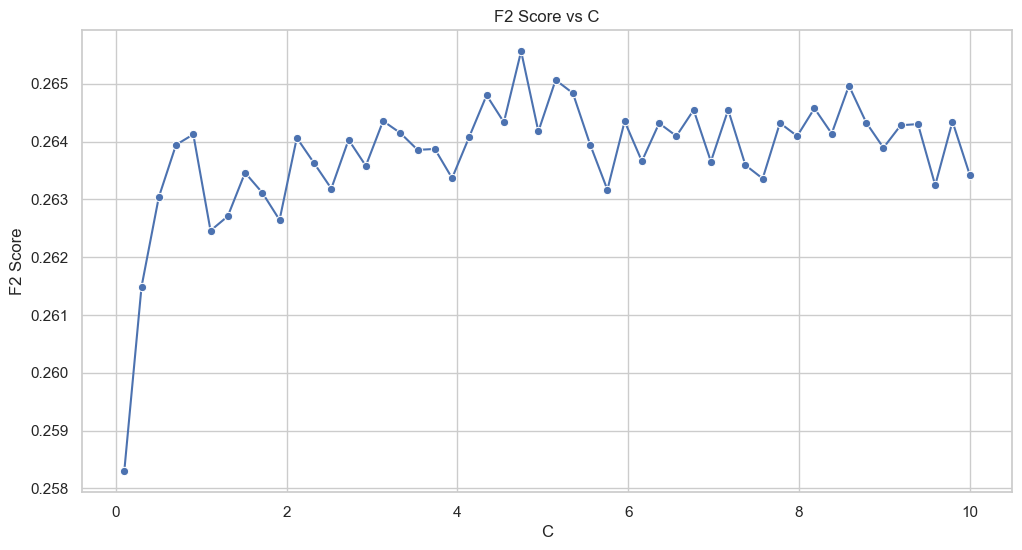

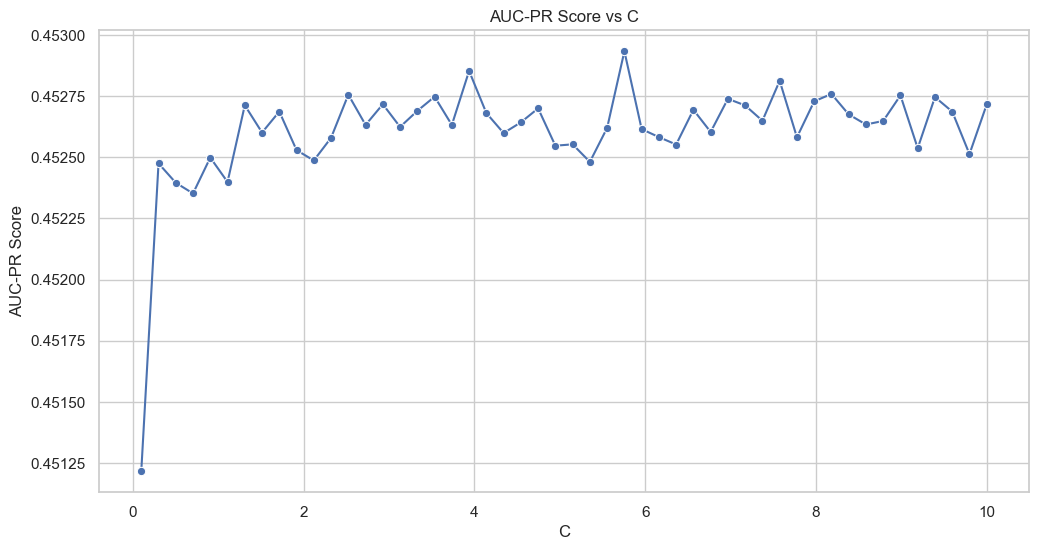

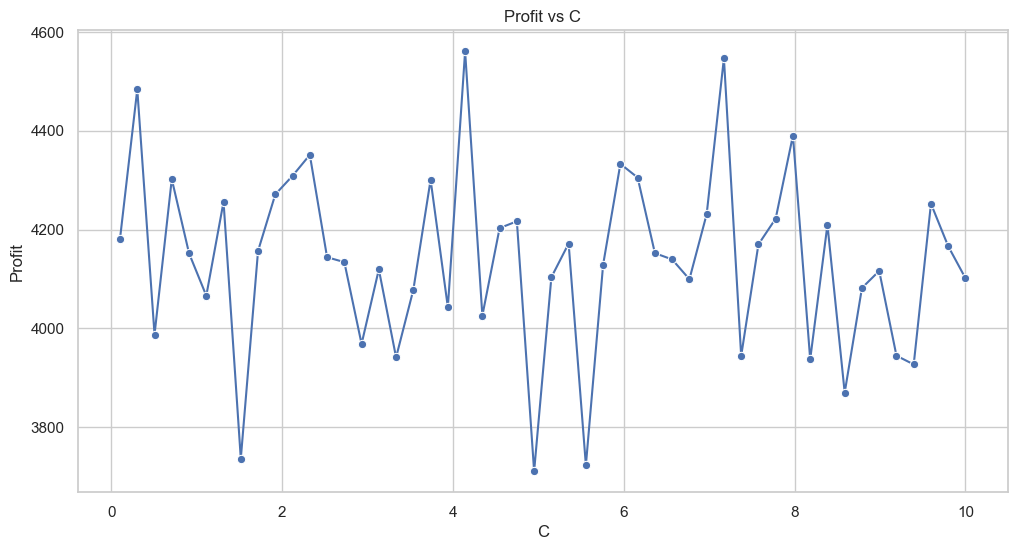

In [113]:
import seaborn as sns
data = pd.DataFrame({
    'C': Cs,
    'F2 Score': f2_scores,
    'AUC-PR Score': aucpr_scores,
    'Profit': profits
})

# Set style for seaborn
sns.set(style="whitegrid")

# List of metrics to plot
metrics = ['F2 Score', 'AUC-PR Score', 'Profit']

# Create separate plots for each metric
for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=data, x='C', y=metric, marker='o')
    
    plt.title(f'{metric} vs C')
    plt.xlabel('C')
    plt.ylabel(metric)
    plt.grid(True)
    
    plt.show()


Метрики довольно слабо меняются от C. На первый взгляд я не нашёл какой-то зависимости прибыли от метрик. Видимо они не дают никакой информации и выборка слишком рандомизированная? Прибыль стала даже хуже, чем до "подбора" гиперпараметров. Но мне всё равно кажется, что в среднем качество, подобранное для f2 score будет лучше, чем для модели без подбора.

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

best_score=0.2655635327491699
best_C=4.746938775510204
best_profit=4474.600637189049
best_C_profit=0.9081632653061225
С по F2:
Общие доходы: 3964.848667765493
Общие расходы: 3246
Общая прибыль: 3964.848667765493

Средняя прибыль на фолд: 792.9697335530985
Стандартное отклонение прибыли: 227.76535843893478
Придётся отдать операторам: 3246
С по прибыли:
Общие доходы: 4103.819591994645
Общие расходы: 3236
Общая прибыль: 4103.819591994645

Средняя прибыль на фолд: 820.7639183989289
Стандартное отклонение прибыли: 234.5353773412658
Придётся отдать операторам: 3236


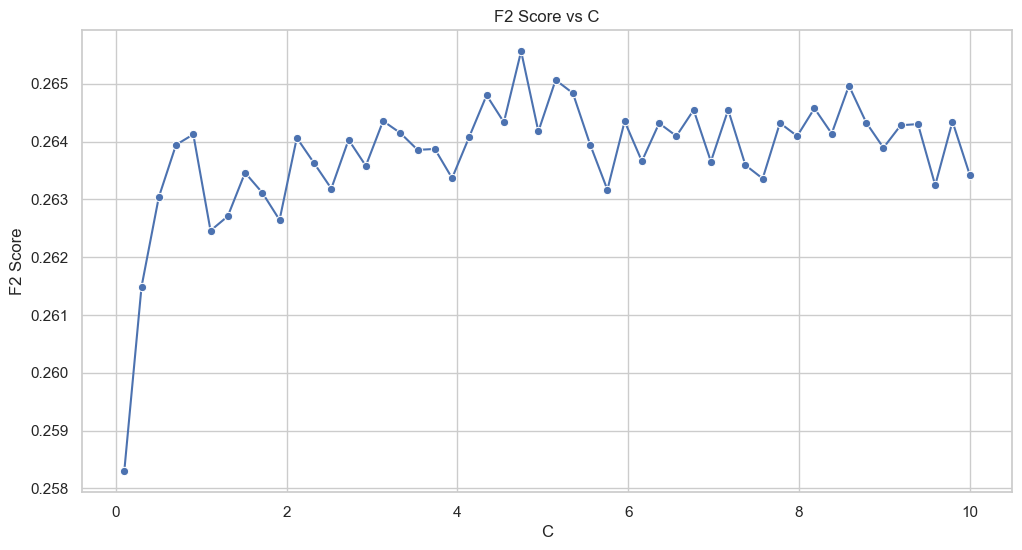

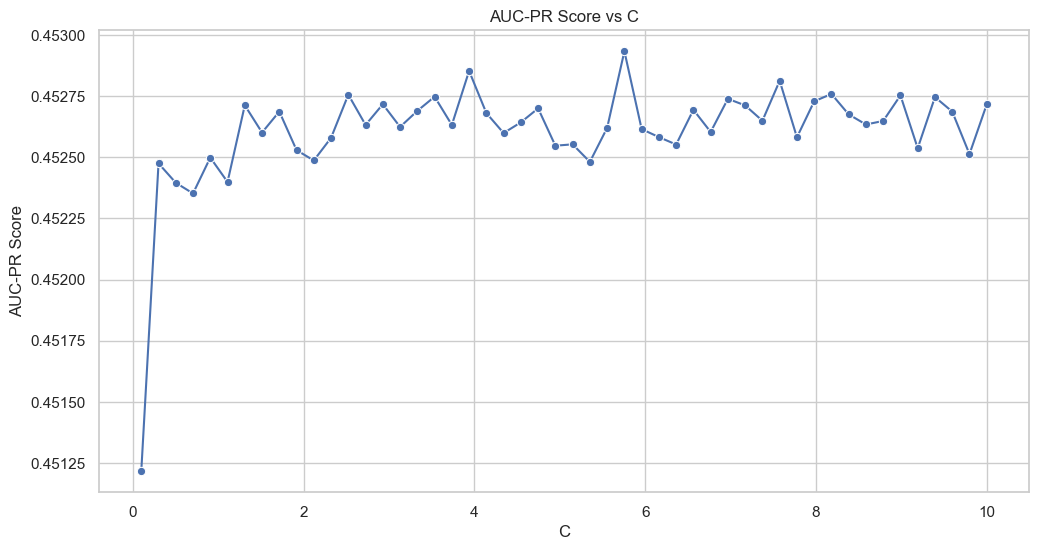

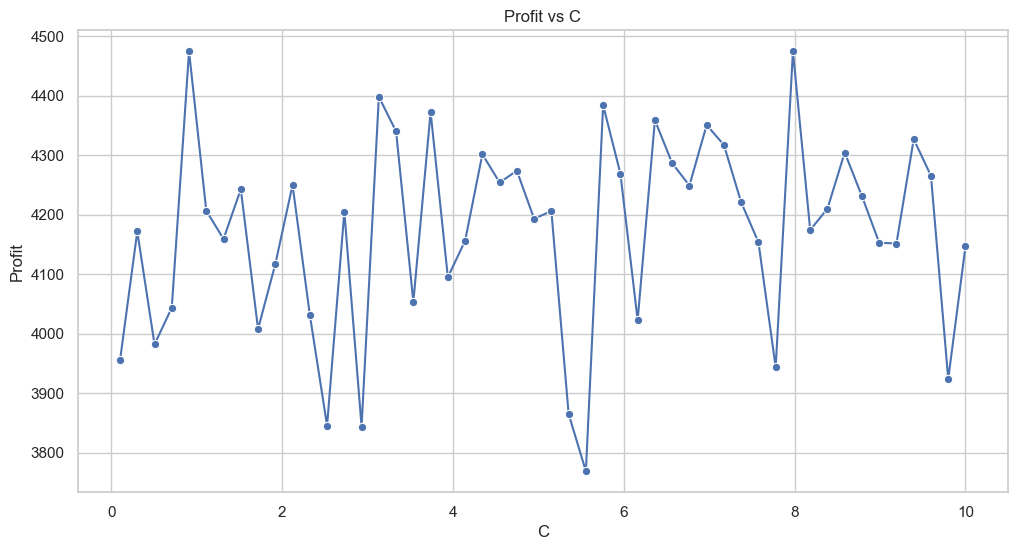

In [114]:
# Запущу те же ячейки ещё раз)
# Максимизировать прибыль не имеет смысла из-за её случайности. Поэтому буду подбирать по f2 скору, как писал выше 
# В любом случае на графиках будет видна возможная максимальная прибыль
# Ладно, добавлю также максимизацию прибыли, но это не имеет смысла(
Cs = np.linspace(0.1, 10, 50)
f2_scores = []
aucpr_scores = []
profits = []

best_score = float("-inf")
best_C = -1

best_profit = float("-inf")
best_C_profit = -1
for C in Cs:
    validation = cross_validate(X, y, C=C)
    validation_score = validation["f2_score test"].mean()
    f2_scores.append(validation_score)
    aucpr_scores.append(validation["AUC-PR test"].mean())
    profit = validation["profit($)"].sum()
    profits.append(profit)

    if validation_score > best_score:
        best_score = validation_score
        best_C = C

    if profit > best_profit:
        best_profit = profit
        best_C_profit = C

print(f"{best_score=}")
print(f"{best_C=}")

print(f"{best_profit=}")
print(f"{best_C_profit=}")
print("С по F2:")
validation = cross_validate(X, y, C=best_C)
print("Общие доходы:", validation["profit($)"].sum())
print("Общие расходы:", validation["cost($)"].sum())
print("Общая прибыль:", validation["profit($)"].sum())
print()
print("Средняя прибыль на фолд:", validation["profit($)"].mean())
print("Стандартное отклонение прибыли:", validation["profit($)"].std())
print("Придётся отдать операторам:", validation["cost($)"].sum())
print("С по прибыли:")
validation = cross_validate(X, y, C=best_C_profit)
print("Общие доходы:", validation["profit($)"].sum())
print("Общие расходы:", validation["cost($)"].sum())
print("Общая прибыль:", validation["profit($)"].sum())
print()
print("Средняя прибыль на фолд:", validation["profit($)"].mean())
print("Стандартное отклонение прибыли:", validation["profit($)"].std())
print("Придётся отдать операторам:", validation["cost($)"].sum())
import seaborn as sns

data = pd.DataFrame({
    'C': Cs,
    'F2 Score': f2_scores,
    'AUC-PR Score': aucpr_scores,
    'Profit': profits
})

# Set style for seaborn
sns.set(style="whitegrid")

# List of metrics to plot
metrics = ['F2 Score', 'AUC-PR Score', 'Profit']

# Create separate plots for each metric
for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=data, x='C', y=metric, marker='o')

    plt.title(f'{metric} vs C')
    plt.xlabel('C')
    plt.ylabel(metric)
    plt.grid(True)

    plt.show()

Нет, для прибыли каждый раз находятся новые коэффициенты, но для метрик - одинаковый (видимо такой вывод я и должен был сделать по заданию, что нельзя подбирать по рандомизированным бизнес метрикам). График метрик не поменялся. График прибыли поменялся, ведь он сильно рандомизированный. Можно сделать вывод, что я всё сделал правильно, и нужно подбирать по стандартным метрикам, а не по бизнес метрикам

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Как я уже писал важнее recall, потому что нам нужно найти как можно больше клиентов и затраты в 5 раз меньше прибыли



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [115]:
# Буду также подбирать и по прибыли и по f2
# Про C в задании не сказано, но в следующем оказалось, что нужно использовать предыдущий, 
# так что возьму лучший c для прибыли, как просят ниже
# Скорее всего, лучше подошёл бы auc pr, так как непонятно какой брать B до подбора признаков (возможно нужен f10)
thresholds = np.linspace(0, 1, 101)
f2_scores = []
aucpr_scores = []
profits = []

best_score = float("-inf")
best_threshold = -1

best_profit = float("-inf")
best_threshold_profit = -1
for threshold in thresholds:
    validation = cross_validate(X, y, threshold=threshold, C=best_C_profit)
    validation_score = validation["f2_score test"].mean()
    f2_scores.append(validation_score)
    aucpr_scores.append(validation["AUC-PR test"].mean())
    profit = validation["profit($)"].sum()
    profits.append(profit)
    
    if validation_score > best_score:
        best_score = validation_score
        best_threshold = threshold
        
    if profit > best_profit:
        best_profit = profit
        best_threshold_profit = threshold
    
print(f"{best_score=}")
print(f"{best_threshold=}")

print(f"{best_profit=}")
print(f"{best_threshold_profit=}")

best_score=0.5448636439884552
best_threshold=0.14
best_profit=4925.0297030172405
best_threshold_profit=0.43


In [116]:
print("threshold по прибыли:")
validation = cross_validate(X, y, threshold=best_threshold_profit, C=best_C_profit)
print("Общие доходы:", validation["profit($)"].sum())
print("Общие расходы:", validation["cost($)"].sum())
print("Общая прибыль:", validation["profit($)"].sum())
print()
print("Средний прибыли на фолд:", validation["profit($)"].mean())
print("Стандартное отклонение прибыли:", validation["profit($)"].std())
print("Придётся отдать операторам:", validation["cost($)"].sum())

threshold по прибыли:
Общие доходы: 4370.86338430525
Общие расходы: 4462
Общая прибыль: 4370.86338430525

Средний прибыли на фолд: 874.17267686105
Стандартное отклонение прибыли: 219.49369247385866
Придётся отдать операторам: 4462


Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог

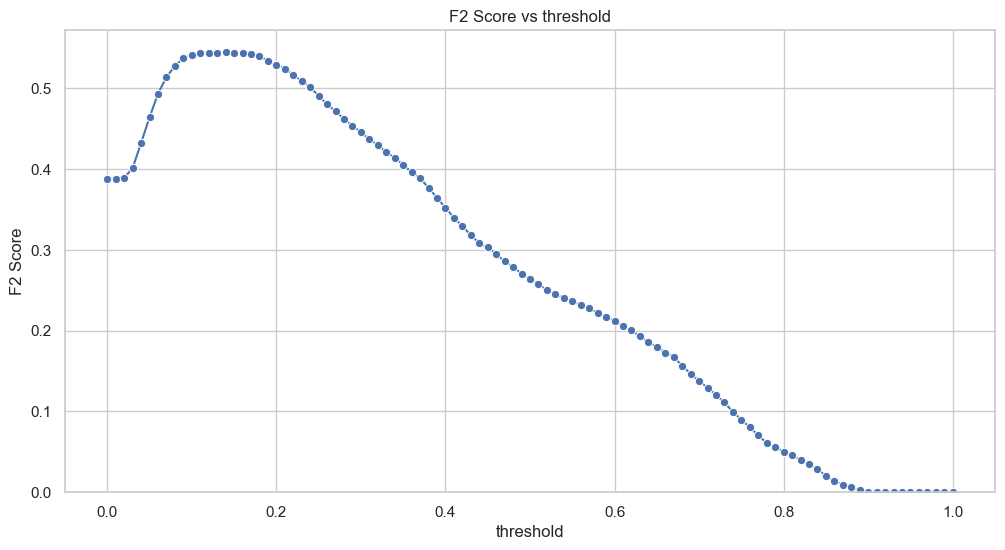

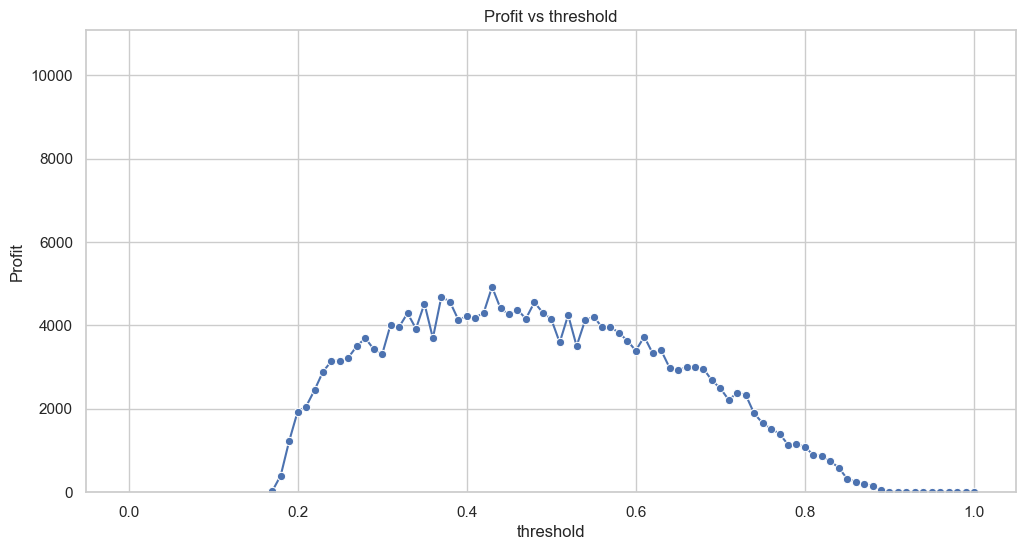

In [117]:
import seaborn as sns
data = pd.DataFrame({
    'threshold': thresholds,
    'F2 Score': f2_scores,
    'AUC-PR Score': aucpr_scores,
    'Profit': profits
})

# Set style for seaborn
sns.set(style="whitegrid")

# List of metrics to plot
metrics = ['F2 Score', 'Profit']

# Create separate plots for each metric
for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=data, x='threshold', y=metric, marker='o')
    
    plt.title(f'{metric} vs threshold')
    plt.xlabel('threshold')
    plt.ylabel(metric)
    plt.grid(True)
    
    plt.ylim(0, None)
    
    plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

In [118]:
y.value_counts() # брать сразу все значения не получится (на всякий случай проверю)

y
False    36548
True      4640
Name: count, dtype: int64

__Ответ:__ Да, для этой задачи слишком маленький порог очень сильно уменьшает прибыль из-за дисбаланса классов. Наилучшие пороги лежат около 0.4. Порог в этой области, так как нам всё таки важен recall и найти всех потенциальных клиетов, но цена ошибки слишком высока, чтобы опускать его низко. 
Также заметил, что f2 score для данной задачи не подходит и моя гипотеза о большей важности recall оказалась ложной. Скорее следовало использовать pr auc и подбирать порог по прибыли

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [119]:
validation = cross_validate(X, y, threshold=best_threshold_profit, C=best_C)
print("Общие доходы:", validation["profit($)"].sum())
print("Общие расходы:", validation["cost($)"].sum())
print("Общая прибыль:", validation["profit($)"].sum())
print()
optimized_profit = validation["profit($)"]
optimized_mean_profit = validation["profit($)"].mean()
optimized_std_profit = validation["profit($)"].std()
print("Средняя прибыль по фолдам:", optimized_mean_profit)
print("Стандартное отклонение прибыли по фолдам:", optimized_std_profit)
print("Придётся отдать операторам:", validation["cost($)"].sum())

Общие доходы: 4352.017264389649
Общие расходы: 4520
Общая прибыль: 4352.017264389649

Средняя прибыль по фолдам: 870.4034528779299
Стандартное отклонение прибыли по фолдам: 120.52971218741018
Придётся отдать операторам: 4520


In [120]:
validation = cross_validate(X, y)
print("Общие доходы:", validation["profit($)"].sum())
print("Общие расходы:", validation["cost($)"].sum())
print("Общая прибыль:", validation["profit($)"].sum())
print()
default_profit = validation["profit($)"]
default_mean_profit = validation["profit($)"].mean()
default_std_profit = validation["profit($)"].std()
print("Средняя прибыль по фолдам:", optimized_mean_profit)
print("Стандартное отклонение дохода по фолдам:", optimized_std_profit)
print("Придётся отдать операторам:", validation["cost($)"].sum())

Общие доходы: 4039.2904471226148
Общие расходы: 3212
Общая прибыль: 4039.2904471226148

Средняя прибыль по фолдам: 870.4034528779299
Стандартное отклонение дохода по фолдам: 120.52971218741018
Придётся отдать операторам: 3212


In [121]:
from scipy.stats import ttest_rel

t_stat, p_value = ttest_rel(optimized_profit, default_profit)

In [122]:
p_value 

0.42657881155224325

*Вывод* p_value больше 0.05, значит результаты статистически незначимы и нельзя сказать, что улучшение модели хоть чем-то помогают. Скорее сама модель слишком слабая для данной задачи.

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ Гречка.